## Исследование данных о российском кинопрокате



## Описание проекта

Заказчик этого исследования — Министерство культуры Российской Федерации.

Необходимо изучить рынок российского кинопроката и выявить текущие тренды. 

Особое внимание необходимо уделить фильмам, которые получили государственную поддержку. Сделать вывод, насколько такие фильмы интересны зрителю.
Данные для исследования опубликованны на портале открытых данных Министерства культуры. Набор данных содержит информацию о прокатных удостоверениях, сборах и государственной поддержке фильмов, а также информацию с сайта КиноПоиск.

### Описание данных

Таблица `mkrf_movies` содержит информацию из реестра прокатных удостоверений. У одного фильма может быть несколько прокатных удостоверений.
- `title` — название фильма;
- `puNumber` — номер прокатного удостоверения;
- `show_start_date` — дата премьеры фильма;
- `type` — тип фильма;
- `film_studio` — студия-производитель;
- `production_country` — страна-производитель;
- `director` — режиссёр;
- `producer` — продюсер;
- `age_restriction` — возрастная категория;
- `refundable_support` — объём возвратных средств государственной поддержки;
- `nonrefundable_support` — объём невозвратных средств государственной поддержки;
- `financing_source` — источник государственного финансирования;
- `budget` — общий бюджет фильма;
- `ratings` — рейтинг фильма на КиноПоиске;
- `genres` — жанр фильма.

Cтолбец `budget` уже включает в себя полный объём государственной поддержки. Данные в этом столбце указаны только для тех фильмов, которые получили государственную поддержку.

Таблица `mkrf_shows` содержит сведения о показах фильмов в российских кинотеатрах.

- `puNumber` — номер прокатного удостоверения;
- `box_office` — сборы в рублях.

### Шаг 1. Откройте файлы с данными и объедините их в один датафрейм. 

Объедините данные таким образом, чтобы все объекты из датасета `mkrf_movies` обязательно вошли в получившийся датафрейм. 

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_0" aria-expanded="false" aria-controls="collapseHint_0">Подсказка</button>
        </div>
        <div id="collapseHint_0" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
Обратите внимание на тип данных столбца, по которому будете соединять датафреймы. Тип данных этих столбцов должен быть одинаковым в обоих датафреймах.
            </div>
        </div>
    </div>
</div>

#### 1.1  Импортируем необходимые для работы библиотеки

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

pd.options.display.float_format = '{:,.2f}'.format
FORMAT_DATE = '%Y-%m-%dT%H:%M:%S'

#### 1.2  Загружаем данные из файлов `mkrf_movies.csv` и `mkrf_shows.csv`   в датафреймы `data_movies` и `data_shows` с разделителем `sep = ','`

In [3]:
try: 
    data_movies = pd.read_csv('/datasets/mkrf_movies.csv', sep = ',') 
    data_shows = pd.read_csv('/datasets/mkrf_shows.csv', sep = ',')  
except FileNotFoundError:
    data_movies = pd.read_csv('https://code.s3.yandex.net/datasets/mkrf_movies.csv', sep = ',') 
    data_shows = pd.read_csv('https://code.s3.yandex.net/datasets/mkrf_shows.csv', sep = ',')    

#### 1.3 Посмотрим информацию о загруженных датафреймах

In [4]:
data_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   puNumber               7486 non-null   object 
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
dtypes: f

In [5]:
data_shows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   puNumber    3158 non-null   int64  
 1   box_office  3158 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 49.5 KB


Датафреймы нужно будет объединить по столбцу `puNumber` — номер прокатного удостоверения. Для объединения необходимо привести тип данный в датафрейме `data_movies` к `int` и проверить корректность введенных данных

#### 1.4 Посмотрим уникальные значения в `data_movies['puNumber']`

In [6]:
data_movies['puNumber'].sort_values().unique()

array([' 111004112', '111000110', '111000111', ..., '231001012',
       '231001111', 'нет'], dtype=object)

Есть пробел в написании номера прокатного удостоверения `' 111004112'`(возможно их больше), а также есть строковое значение `'нет'`. Для преобразования необходимо убрать пробелы, а так же заменить `'нет'` на `0`.
Далее удалим пробелы, заменим `'нет'` на `0` и преобразуем тип в `int`.

In [7]:
data_movies['puNumber'] = data_movies['puNumber'].str.strip()
data_movies.loc[data_movies['puNumber'] == 'нет', 'puNumber'] = 0
data_movies['puNumber'] = data_movies['puNumber'].astype('int64')

#### 1.5 Объединим датафреймы

In [8]:
data = data_movies.merge(data_shows, on='puNumber', how='left')

#### 1.6 Выведем на экран первые пять строк объединенного датаврейма и посмотрим информацию о нем

In [9]:
data.head()

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
0,Открытый простор,221048915,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама",NaN
1,Особо важное задание,111013716,2016-09-13T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный",NaN
2,Особо опасен,221038416,2016-10-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
3,Особо опасен,221026916,2016-06-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
4,Особо опасен,221030815,2015-07-29T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7486 entries, 0 to 7485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   puNumber               7486 non-null   int64  
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
 15  box_

#### Вывод:

- Датафреймы объединены без потерь;
- Значения отсутствующих прокатных удостоверений теперь нулевые.

### Шаг 2. Предобработка данных

#### Шаг 2.1. Проверьте типы данных

- Проверьте типы данных в датафрейме и преобразуйте их там, где это необходимо.
   
#### 2.1.1 Преобразуем `show_start_date` в `datetime`

In [11]:
data['show_start_date'] = pd.to_datetime(data['show_start_date'], format=FORMAT_DATE).dt.tz_localize(None)

   #### 2.1.2 Преобразуем тип столбца `ratings ` в тип `float`.
  
  Сначала проверим корректность значений столбца для преобразования. Посмотрим уникальные значения.  

In [12]:
data['ratings'].sort_values().unique()

array(['1.0', '1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7', '1.8',
       '1.9', '19%', '2.1', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9',
       '28%', '3.0', '3.1', '3.2', '3.3', '3.4', '3.5', '3.6', '3.7',
       '3.8', '3.9', '4.0', '4.1', '4.2', '4.3', '4.4', '4.5', '4.6',
       '4.7', '4.8', '4.9', '5.0', '5.1', '5.2', '5.3', '5.4', '5.5',
       '5.6', '5.7', '5.8', '5.9', '6.0', '6.1', '6.2', '6.3', '6.4',
       '6.5', '6.6', '6.7', '6.8', '6.9', '62%', '64%', '7.0', '7.1',
       '7.2', '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '79%',
       '8.0', '8.1', '8.2', '8.3', '8.4', '8.5', '8.6', '8.7', '8.8',
       '8.9', '83%', '88%', '89%', '9.0', '9.1', '9.2', '90%', '91%',
       '94%', '97%', '98%', '99%', nan], dtype=object)

В уникальных значения рейтинга можно заметить процентные значения (`19%`, `28%`, `62%`, `64%`, `79%`, `83%`, `88%`, `89%`, `90%`, `91%`, `94%`, `97%`, `98%`, `99%`). Рейтин в процентах не считается. Формулы гораздо сложнее. Вполне возможно это банальные опечатки. Должно быть: `1.9`, `2.8`, `6.2`, `6.4`, `7.9`, `8.3`, `8.8`, `8.9`, `9.0`, `9.1`, `9.4`, `9.7`, `9.8`, `9.9`. Посмотрим, что это за фильмы.

In [13]:
data.loc[data['ratings'].str.contains('%') == True].sort_values(by='ratings')

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
3431,Наурыз,131000217,2017-03-09 12:00:00,Художественный,Эс Джи,Республика Казахстан,Аскар Бисембин,"Олег Головашкин, Алмас Султангазин",«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,19%,комедия,"37,960.00"
811,От винта!,114000212,2012-08-06 12:00:00,Анимационный,"ЗАО ""Продюсерский центр ""Парадиз""",Россия,О.Лопато,"Г.Нерсисян, А.Манасарян, А.Нерсесян",«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,28%,"детский,приключения,комедия","1,740.00"
2438,Самый рыжий Лис,111012715,2015-07-30 12:00:00,Художественный,"ООО ""Продюсерский центр ""Ленфильм""",Россия,А.Стреляная,"А.Котелевский, Э.Пичугин",«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,62%,"фэнтези,семейный",NaN
1899,Золушка /По сказке Шарля Перро/. Холодное торж...,121003615,2015-02-27 12:00:00,Художественный,"Женр Филмз, Уолт Дисней Пикчерз",США,Кеннет Брана,"Дэвид Бэррон, Саймон Кинберг, Эллисон Ширмур",«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,64%,"мюзикл,фэнтези,мелодрама","528,732,557.70"
7159,Анна Каренина. Интимный дневник,111013919,2019-10-23 12:00:00,Художественный,"ООО ""РТВ""",Россия,Ю.Грымов,Ю.Грымов,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,79%,драма,"182,882.50"
2680,Год Белого Слона,111003915,2015-04-08 12:00:00,Художественный,"ООО ""Творческое объединение ЮГ""",Россия,Ю.Грымов,П.Поляков,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,79%,семейный,NaN
3446,Короткие истории о любви - 4,126006316,2016-12-30 12:00:00,Прочие,"Нетворг Айлэнд Телевижн, Магнетфильм, Шорткатс...",Великобритания - Аргентина - США - Франция - Р...,"Д.Адар, П.Антохин, М.Биасин, А.Бурунова, К.Кол...","Д.Адар, Д.Амсон, П.Антохин, А.Армстронг, С.Бил...",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,83%,NaN,"2,266,408.00"
5455,Вечный холод,111006417,2017-08-28 12:00:00,Художественный,"ЗАО ""Производственный комплекс ""ГЛАВКИНО"", ООО...",Россия,А.Мигачев,И.Бачурин,«18+» - запрещено для детей,NaN,NaN,NaN,NaN,83%,"фэнтези,боевик,триллер",NaN
1874,Короткие истории о любви 2,121002615,2015-02-13 12:00:00,Художественный,"Кавиар, Курт 13, СтритЛайт Филмз, Нэйер Дойче ...",Нидерланды - США - Германия - Канада - Франция...,"Мэтью Аувро, Лео Брайдл, Бен Бренд, Ден Кларк,...","Мэри Пэт Бентел, Бен Бренд, Сиара Гиллан, Джор...",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,83%,NaN,"1,429,859.00"
5332,Добыча.,121009411,2011-06-15 12:00:00,Художественный,Афтер Дарк Филмз,США,Патрик Сиверсен,"Закари Ти Брайан, Кристофер",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,88%,"фантастика,боевик,триллер",NaN


В выведенном списке присутсвуют фильмы, которые на данные момент либо не имеют рейтинга, либо имеют рейтинг, не соответсвующий например делению 99 на 10. 9.9 нету таких рейтингов. Возможно такие и были в моменте, но анализируя данные фильмы врядли. 
Поэтому заменим данные значения на `nan` и поменяем тип данных. 

In [14]:
data['ratings'] = pd.to_numeric(data['ratings'], errors ="coerce")

In [15]:
data['ratings'].sort_values().unique()

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.1, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
       7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ,
       9.1, 9.2, nan])

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7486 entries, 0 to 7485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  7486 non-null   object        
 1   puNumber               7486 non-null   int64         
 2   show_start_date        7486 non-null   datetime64[ns]
 3   type                   7486 non-null   object        
 4   film_studio            7468 non-null   object        
 5   production_country     7484 non-null   object        
 6   director               7477 non-null   object        
 7   producer               6918 non-null   object        
 8   age_restriction        7486 non-null   object        
 9   refundable_support     332 non-null    float64       
 10  nonrefundable_support  332 non-null    float64       
 11  budget                 332 non-null    float64       
 12  financing_source       332 non-null    object        
 13  rat

Для следующих шагов посмотрим количество пропущенных значений по столбцам

In [17]:
data.isna().sum()

title                       0
puNumber                    0
show_start_date             0
type                        0
film_studio                18
production_country          2
director                    9
producer                  568
age_restriction             0
refundable_support       7154
nonrefundable_support    7154
budget                   7154
financing_source         7154
ratings                   996
genres                    976
box_office               4328
dtype: int64

#### Вывод:

- Типы данных заменены;
- Значения `ratings` исправлены.

Из `data.info()` видно, что есть пропуски в столбцах:

- `film_studio` - 18 пропусков;
- `production_country` - 2 пропуска;
- `director` - 9 пропусков;
- `producer` - 568 пропусков;
- `refundable_support`, `nonrefundable_support`, `budget`, `financing_source` всего 332 заполненных значения;
- `ratings` - 996 пропусков;
- `genres` - 976 пропусков;
- `box_office` - 4328 пропусков;

Далее в шаге **2.2** детально рассмотрим эти пропуски.

#### Шаг 2.2. Изучите пропуски в датафрейме

- Объясните, почему заполнили пропуски определённым образом или почему не стали этого делать.

Поэтапно рассмотрим пропущенные значения.

Начнем от меньшего к большему.

#### 2.2.1 Пропуски в столбце `production_country`.

В данном стобце всего два пропуска.
Посмотрим, что это за пропуски.

In [18]:
data.loc[data['production_country'].isna()]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
3186,"Детский юмористический киножурнал ""Ералаш. Ну ...",111001216,2016-02-09 12:00:00,Художественный,"ООО ""Продюсерский центр ЕРАЛАШ""",NaN,"Р.Светлов, И.Магитон, А.Арутюнян, Л.Мирский, А...","ООО ""Продюсерский центр ЕРАЛАШ""",«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,7.20,"детский,комедия","194,527.00"
4441,Мульт личности. Выпуск 5,214000410,2010-01-25 12:00:00,Художественный,NaN,NaN,NaN,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,4.00,"мультфильм,комедия",NaN


В этом столбце оба пропуска это фильмы из России. Поэтому можно заменить эти пропуски на `"Россия"`

In [19]:
data.loc[data['production_country'].isna() == True, 'production_country'] = 'Россия'

In [20]:
data['production_country'].isna().sum()

0

Значение изменено. Пропусков нету.

#### 2.2.2 Пропуски в столбце `director`.

В столбце 9 пропусков.

In [21]:
data.loc[data['director'].isna()]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
764,"Три звезды. Концерт в Waldbuhne Theater, Берли...",126003512,2012-12-04 12:00:00,Прочие,Райзинг Алтернатив,Великобритания,NaN,Вальдбюне Театр,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,NaN,"44,350.00"
1735,Помпеи. Британский музей,126003413,2013-09-11 12:00:00,Прочие,"МортуСкрин, Британский музей",Великобритания,NaN,Британский музей,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3840,Зур концерт (Большой концерт).,217027010,2010-06-24 12:00:00,Художественный,"ООО ""Барс Рекордс""",Россия,NaN,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4052,"Ганс Сэйфуллин ""Авылым чишмэлэре. Ганс Сэйфулл...",217017310,2010-04-22 12:00:00,Художественный,"ООО ""Барс-Рекордс""",Россия,NaN,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4298,Изге Вэли (Святой Валентин),217020610,2010-05-20 12:00:00,Художественный,"ООО ""Барс Рекордс""",Россия,NaN,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4415,Bon Jovi. The Circle Tour,126001710,2010-11-11 12:00:00,Прочие,Эншутц Интертейнмент Груп,США,NaN,Эншутц Интертейнмент Груп,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,7.90,"концерт,музыка",NaN
4441,Мульт личности. Выпуск 5,214000410,2010-01-25 12:00:00,Художественный,NaN,Россия,NaN,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,4.00,"мультфильм,комедия",NaN
4923,Георг Фридрих Гендель. Мессия. Оратория. Корол...,126001111,2011-04-25 12:00:00,Прочие,Опус Арт,Великобритания,NaN,Короевский колледж Кембриджа,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4942,Питер Гэбриэл и New Blood Orchestra 3D,126002711,2011-11-11 12:00:00,Прочие,Омниверс Визион,Великобритания,NaN,Омниверс Визион,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,6.70,"концерт,музыка",NaN


Часть из перечисленных картин это концерты, где и режиссер отсутствует. Оставляем как есть.

#### 2.2.3 Пропуски в столбце `film_studio`.

In [22]:
data.loc[data['film_studio'].isna()]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
1293,Stars in Shorts,121011114,2014-06-03 12:00:00,Художественный,NaN,"США, Великобритания","Роберт Фестингер, Руперт Френд, Джей Камен, Ни...","Татьяна Келли, Роберта Мунро, Руперт Френд, До...",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.30,комедия,NaN
4441,Мульт личности. Выпуск 5,214000410,2010-01-25 12:00:00,Художественный,NaN,Россия,NaN,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,4.00,"мультфильм,комедия",NaN
6105,Значит любит,111013818,2018-08-10 12:00:00,Художественный,NaN,Россия,А.Краевский,Е.Щербакова,«18+» - запрещено для детей,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6181,Несейка. Младшая дочь,112007018,2018-09-01 12:00:00,Документальный,NaN,Россия,В.Марин,"Д.Якунин, Ф.Абрютин, О.Филонова",«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6379,Ян Антонышев,112011818,2018-11-15 12:00:00,Документальный,NaN,Россия,Е.Окопная,Е.Герасимов,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6380,Ян Антонышев,112011918,2018-11-15 12:00:00,Документальный,NaN,Россия,Е.Окопная,Е.Герасимов,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6399,Доживем до каникул?..,111021918,2018-11-15 12:00:00,Художественный,NaN,Россия,Я.Хальпукова (псевдоним Яна Мартынец),Я.Хальпукова (псевдоним Яна Мартынец),«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,"41,225.00"
6485,До и После,112014418,2018-12-05 12:00:00,Документальный,NaN,Россия,А.Новокреповская,А.Новокреповская,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.90,"драма,криминал,детектив",NaN
6494,Калмыцкий геше Нгаванг Вангьял,113002018,2018-12-05 12:00:00,Научно-популярный,NaN,Россия,И.Долгина,И.Долгина,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6497,Мой папа Чингисхан,112014918,2018-12-06 12:00:00,Документальный,NaN,Россия,А.Сайфуллина,А.Сайфуллина,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Проанализировав вышеперечисленные фильмы оказалось, что большинство это документальные или авторские фильмы.

Только 2 позиции имеют студию:

- `Stars in Shorts - Biscuit Pictures, Mission Filmworks, Contemptible Entertainment`
- `Мульт личности. Выпуск 5 - Первый канал`

Их можно заменить точечно, остальные оставляем как есть.

In [23]:
data.loc[data['title'] == "Stars in Shorts", 'film_studio'] = 'Бисквит пикчерз, Мишн фильворкс, Контентибл интертеймент'
data.loc[data['title'] == "Мульт личности. Выпуск 5", 'film_studio'] = 'Первый канал'

Проверим правильность заполнения пропусков.

In [24]:
data.loc[(data['title'] == "Stars in Shorts") | (data['title'] == "Мульт личности. Выпуск 5")]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
1293,Stars in Shorts,121011114,2014-06-03 12:00:00,Художественный,"Бисквит пикчерз, Мишн фильворкс, Контентибл ин...","США, Великобритания","Роберт Фестингер, Руперт Френд, Джей Камен, Ни...","Татьяна Келли, Роберта Мунро, Руперт Френд, До...",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.30,комедия,NaN
4441,Мульт личности. Выпуск 5,214000410,2010-01-25 12:00:00,Художественный,Первый канал,Россия,NaN,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,4.00,"мультфильм,комедия",NaN


2 пропуска заполнили правильно

#### 2.2.4 Пропуски в столбце `producer`.

In [25]:
data.loc[data['producer'].isna()]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
1,Особо важное задание,111013716,2016-09-13 12:00:00,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.60,"драма,военный",NaN
5,Остановился поезд,111013816,2016-09-13 12:00:00,Художественный,"Киностудия ""Мосфильм""",СССР,В.Абдрашитов,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,7.70,драма,NaN
6,Любовь и голуби,111007013,2013-10-18 12:00:00,Художественный,"Киностудия ""Мосфильм""",СССР,В.Меньшов,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,8.30,"мелодрама,комедия","2,700.00"
9,Отпуск за свой счет,111019114,2014-12-01 12:00:00,Художественный,"Киностудия ""Мосфильм"", Телевидение ВНР","СССР, Венгрия",В.Титов,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,7.80,"мелодрама,комедия",NaN
11,Ответный ход,111019014,2014-12-01 12:00:00,Художественный,"Киностудия ""Мосфильм""",СССР,М.Туманишвили,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,7.80,"боевик,драма,приключения",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7405,Отряд специального назначения,111020419,2019-12-01 12:00:00,Художественный,Свердловская киностудия,СССР,Г.Кузнецов,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,7.00,"приключения,военный",NaN
7406,Назначаешься внучкой,111020519,2019-12-01 12:00:00,Художественный,Свердловская киностудия,СССР,Я.Лапшин,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,7.00,военный,NaN
7407,Перед рассветом,111020619,2019-12-01 12:00:00,Художественный,Свердловская киностудия,СССР,Я.Лапшин,NaN,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.90,"драма,мелодрама",NaN
7408,Ты помнишь,111020719,2019-12-01 12:00:00,Художественный,Свердловская киностудия,СССР,О.Николаевский,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,7.00,"драма,мелодрама,военный",NaN


Оставляем как есть, т.к. большая чать этих строк - это фильмы производства `СССР`, а тогда и продюссеров то не было..

#### 2.2.5 Пропуски в столбцах `refundable_support`, `nonrefundable_support`, `budget`, `financing_source`.

Имеем всего 332 заполненных значения. Т.к. столбцы `refundable_support`, `nonrefundable_support`,`financing_source` связаны с гос. поддержкой, то остальные пропуски заполнить не получится. И столбец бюджет `budget`то же 332 значения. Все взаимосвязано.

In [26]:
data.loc[data['budget'].isna() == False]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
1281,Пока еще жива,111005313,2013-10-11 12:00:00,Художественный,"АНО содействия развитию кинематографии ""Ангел-...",Россия,А.Атанесян,"А.Атанесян, М.Бабаханов, Р.Бутко",«16+» - для детей старше 16 лет,0.00,"26,500,000.00","79,411,900.00",Министерство культуры,8.10,"драма,мелодрама","365,353.60"
1448,Бесславные придурки,111003314,2014-03-28 12:00:00,Художественный,"ООО ""Компания ""АТК-Студио""",Россия,А.Якимчук,А.Тютрюмов,«12+» - для детей старше 12 лет,0.00,"26,000,000.00","37,142,857.00",Министерство культуры,NaN,NaN,"28,140.00"
1498,Невидимки,111004213,2013-09-10 12:00:00,Художественный,"ООО ""Компания ""РЕАЛ-ДАКОТА""",Россия,"Р.Давлетьяров, С.Комаров","Р.Давлетьяров, А.Котелевский, А.Олейников",«12+» - для детей старше 12 лет,0.00,"107,847,945.00","176,023,490.00",Фонд кино,5.30,"комедия,фантастика","19,957,031.50"
1524,БЕРЦЫ,111004314,2014-05-05 12:00:00,Художественный,"ООО ""Студия ""Пассажир""",Россия,Е.Миндадзе (псевдоним Катя Шагалова),Л.Антонова,«16+» - для детей старше 16 лет,0.00,"28,000,000.00","40,574,140.00",Министерство культуры,4.20,драма,"55,917.50"
1792,Братья Ч,111004414,2014-04-23 12:00:00,Художественный,"ООО ""Студия ""Пассажир""",Россия,М.Угаров,"А.Миндадзе, Л.Антонова",«16+» - для детей старше 16 лет,0.00,"25,000,000.00","40,015,122.00",Министерство культуры,6.40,драма,"232,100.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7464,Союз спасения,111022019,2019-12-26 12:00:00,Художественный,"ЗАО ""Дирекция кино""",Россия,А.Кравчук,"А.Максимов, К.Эрнст",«12+» - для детей старше 12 лет,"100,000,000.00","400,000,000.00","980,000,000.00",Фонд кино,6.00,"история,биография,драма","717,703,185.53"
7466,Иван Царевич и Серый Волк 4,114005019,2019-12-20 12:00:00,Анимационный,"ООО ""Студия анимационного кино ""Мельница""",Россия,"Д.Шмидт, К.Феоктистов","С.Сельянов, А.Боярский",«6+» - для детей старше 6 лет,"100,000,000.00",0.00,"190,000,000.00",Фонд кино,6.70,"мультфильм,приключения,семейный","501,069,235.00"
7474,Вторжение,111022519,2019-12-23 12:00:00,Художественный,"ООО ""Арт Пикчерс Студия"", ООО ""Водород 2011""",Россия,Ф.Бондарчук,"Ф.Бондарчук, М.Врубель, А.Андрющенко, Д.Рудовский",«12+» - для детей старше 12 лет,"100,000,000.00","400,000,000.00","944,000,000.00",Фонд кино,5.70,"фантастика,боевик",NaN
7476,Я свободен,111023019,2019-12-26 12:00:00,Художественный,"АО ""ТПО ""Киностудия им. М.Горького""",Россия,И.Северов,С.Зернов,«12+» - для детей старше 12 лет,0.00,"30,000,000.00","46,154,000.00",Министерство культуры,5.90,драма,NaN


#### 2.2.6 Пропуски в столбцах `ratings` и `genres`.

Оставляем как есть. Рейтинги менять либо медианой, либо средним не будем, т.к. это можем исказить данные. Жанры принципиально можно найти в интернете, но их очень много..

#### 2.2.7 Пропуски в столбце `box_office`.

Оставляем как есть, т.к. пропуски в этом столбце появились в результате слияния датасетов. А во втором датасете было всего 3158 записей.

#### Вывод

В результате обработки пропусков удалось заменить всего несколько значений:
- 2 пропуска в столбце `production_country`
- 2 пропуска в столбце `film_studio`

Остальные пропуски оставляем как есть.

#### Шаг 2.3. Изучите дубликаты в датафрейме
- Проверьте, есть ли в данных дубликаты. Опишите причины, которые могли повлиять на появление дублей.

#### 2.3.1 Проверим на наличие полных дубликатов строк

In [27]:
data.duplicated().sum()

0

Полные дубликаты отсутсвуют.

#### 2.3.2 Проверим на дубликаты по названию фильмов

In [28]:
data['title'].value_counts()

День святого Валентина_                               5
Химера                                                4
Рапунцель: Запутанная история                         4
Белая мгла /По комиксу Грега Рукка и Стива Либера/    4
Дом грёз                                              4
                                                     ..
Охранник                                              1
Открытый простор                                      1
Образцовые семьи                                      1
Во имя чести                                          1
Смерть нам к лицу                                     1
Name: title, Length: 6772, dtype: int64

Видим, что есть фильмы, которые присуствуют несколько раз в датасете. Так же присутсвуют лишние символы (`_`, `.`) в названиях фильмов. Перед дальнейшим анализом устраним эти недочёты методом `strip()`.

In [29]:
data['title'] = data['title'].str.strip("._ !")

In [30]:
data['title'].value_counts()

День святого Валентина                                            5
Волшебная страна                                                  5
Там, где живут чудовища                                           4
Красавчик-2                                                       4
Форсаж 7                                                          4
                                                                 ..
Приключения охотника на драконов                                  1
Жёлтый клевер                                                     1
Райд "Сатурн" из серии "Космический парк 360"                     1
300 спартанцев /По роману-комиксу Фрэнка Миллера и Линн Варли/    1
Твин Пикс: Сквозь огонь                                           1
Name: title, Length: 6676, dtype: int64

Лишние символы убраны. Проверим для примера фильм `Волшебная страна`, который встречается 5 раз

In [31]:
data.loc[data['title'] == "Волшебная страна"]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
107,Волшебная страна,221004716,2016-02-09 12:00:00,Художественный,Филм Колони,США,Марк Форстер,Ричард Н.Глэдстин,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,7.90,"драма,семейный,биография",NaN
936,Волшебная страна,124003016,2016-06-07 12:00:00,Анимационный,"Брейктру Филмз, Эс Эм Бэ Инвестментс",Великобритания - Польша - КНР - Индия - Норвегия,"Мартин Клэпп, Дорота Кобеля, Джофф Линдси","Магдалена Баргел, Хью Велчман",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.90,"драма,семейный,биография","3,750.00"
937,Волшебная страна,124001113,2013-04-15 12:00:00,Анимационный,"Брейктру Филмз, Эс Эм Бэ Инвестментс",Великобритания - Польша - КНР - Индия - Норвегия,"Мартин Клэпп, Дорота Кобеля, Джофф Линдси","Магдалена Баргел, Хью Велчман",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.90,"драма,семейный,биография","20,260.00"
2120,Волшебная страна,124000515,2015-02-05 12:00:00,Анимационный,Чжэцзян Чжунгнань Анимэйшн,КНР,Фанг Лей,Ву Янронг,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,7.90,"драма,семейный,биография","1,171,085.60"
4653,Волшебная страна,221155710,2010-12-17 12:00:00,Художественный,Филм Колони,США,Марк Форстер,Ричард Н.Глэдстин,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,7.90,"драма,семейный,биография",NaN


Видим вообще три разных фильма, но при совпадении названия, типа, студии и страны производства везде разный номер прокатного удостоверения.

Министерство культуры проясняет эту ситуацию:

    "Если прокатное удостоверение на фильм не выдавалось обладателю исключительных прав на этот фильм, то на один фильм может быть выдано несколько прокатных удостоверений лицензиатам на соответствующие способы использования фильма (при этом срок действия каждого прокатного удостоверения будет ограничиваться сроком действия соответствующего лицензионного договора)."

Помимо этого у разных прокатных удостоверений могут быть разные сборы (`box_office`)

Для наглядности проверим еще один фильм, который точно существует в единственном экземпляре:

In [32]:
data.loc[data['title'] == "Знакомство с Факерами 2"]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
4129,Знакомство с Факерами 2,121021710,2010-11-25 12:00:00,Художественный,"Парамаунт Пикчерз, Юниверсал Пикчерз, ДУ Студи...",США,Пол Вайц,"Роберт Де Ниро, Джон Гамбург, Джей Роач, Джейн...",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,6.20,"мелодрама,комедия",NaN
4886,Знакомство с Факерами 2,221034211,2011-04-05 12:00:00,Художественный,"Парамаунт Пикчерз, Юниверсал Пикчерз, ДУ Студи...",США,Пол Вайц,"Роберт Де Ниро, Джон Гамбург, Джей Роач, Джейн...",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,6.20,"мелодрама,комедия",NaN
4989,Знакомство с Факерами 2,221049411,2011-03-30 12:00:00,Художественный,"Парамаунт Пикчерз, Юниверсал Пикчерз, ДУ Студи...",США,Пол Вайц,"Роберт Де Ниро, Джон Гамбург, Джей Роач, Джейн...",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,6.20,"мелодрама,комедия",NaN
5390,Знакомство с Факерами 2,221117511,2011-11-15 12:00:00,Художественный,"Парамаунт Пикчерз, Юниверсал Пикчерз, ДУ Студи...",США,Пол Вайц,"Роберт Де Ниро, Джон Гамбург, Джей Роач, Джейн...",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,6.20,"мелодрама,комедия",NaN


Фильм один и тот же, но прокатные удостоверения и даты выхода в прокат разные

#### 2.3.3 Проверим на дубликаты по одному из основных параметров - номеру прокатного удостоверения

In [33]:
data['puNumber'].value_counts()

221054410    2
221154310    2
0            1
111008518    1
114002716    1
            ..
121021814    1
224028210    1
121013618    1
121017712    1
126002916    1
Name: puNumber, Length: 7484, dtype: int64

Видим два прокатных удостоверения, встречающихся по 2 раза (`221054410` и `221154310`)

Проверим каждое из них:

In [34]:
data.loc[data['puNumber'] == 221054410]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
5067,Анализируй это,221054410,2010-05-25 12:00:00,Художественный,"Уорнер Бразерс, Вилладж Роудшоу Филмз ЛТД",США-Австралия,ХЭрольд Рэмис,"Джейн Розенталь, Пола Уейнстейн",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.40,"комедия,криминал",NaN
5068,Анализируй то,221054410,2010-05-25 12:00:00,Художественный,"Уорнер Бразерс, Виллидж Роадшоу Пикчерз, Эн-Пи...",США,Гарольд Реймис,"Джейн Розенталь, Паул Уэйнстейн",«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,6.80,"комедия,криминал",NaN


In [35]:
data.loc[data['puNumber'] == 221154310]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
4638,Как жениться и остаться холостым,221154310,2010-12-17 12:00:00,Художественный,"Ше Вам, Скрипт Ассосье, Тэ Фэ 1 Фильм Продюксь...",Франция,Эрик Лартиго,"Амандин Било, Алан Шаба",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.00,"мелодрама,комедия",NaN
4639,Иоанна - женщина на папском престоле /По роман...,221154310,2010-12-17 12:00:00,Художественный,"Константин Фильм, А Эр Ди Дегето Фильм, Дюне ...",Германия - Великобритания - Италия - Испания,Зенке Вортманн,"Оливер Бербен, Дорис Д.Хайнце, Фарук Элтан",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.60,"драма,мелодрама,история",NaN


В обоих вариантах одно прокатное удостоверение на 2 фильма. Такое возможно. Оставляем без изменений.

#### Вывод

- Устранены недочеты в названиях фильмов.
- Присутствуют дубликаты в названиях фильмов и прокатных удостоверений. Это связано с системой выдачи прокатных удостоверений. На одно прокатное удостоверение может быть несколько фильмов и один фильм может иметь разные прокатные удостоверения.

#### Шаг 2.4. Изучите категориальные значения

- Посмотрите, какая общая проблема встречается почти во всех категориальных столбцах;
- Исправьте проблемные значения в поле `type`.

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_1" aria-expanded="false" aria-controls="collapseHint_1">Подсказка</button>
        </div>
        <div id="collapseHint_1" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
В поле <code>type</code> есть несколько значений, у которых появился пробел в начале строки. Самый простой способ их «починить» -- использовать метод <a href="https://pandas.pydata.org/docs/reference/api/pandas.Series.str.strip.html#pandas.Series.str.strip">.str.strip</a>. Этот метод удаляет все пробелы, которые встречаются в начале и в конце строки. Применяют его таким образом:<br>
<code>df['type'].str.strip()</code>
            </div>
        </div>
    </div>
</div>

#### Шаг 2.4.1 Проверим категориальные столбцы на правильность заполнения.

Столбец `type`:

In [36]:
data['type'].sort_values().unique()

array([' Анимационный', ' Художественный', 'Анимационный',
       'Документальный', 'Музыкально-развлекательный',
       'Научно-популярный', 'Прочие', 'Художественный'], dtype=object)

Видим пробелы перед названиями категорий. Удалим эти пробелы и выведем на экран результат обработки.

In [37]:
data['type'] = data['type'].str.strip()
data['type'].sort_values().unique()

array(['Анимационный', 'Документальный', 'Музыкально-развлекательный',
       'Научно-популярный', 'Прочие', 'Художественный'], dtype=object)

Столбец `film_studio`:

In [38]:
data['film_studio'].sort_values().unique()

array([' АНО "Кинофорум"',
       ' Ауматик Интертейнмент, Блюмхаус Продакшнз и др.',
       ' ЗАО "Кинокомпания ФаворитФильм" по заказу ООО "ФАВОРИТ МЕДИА"',
       ...,
       'совместное производство Киностудия "Мосфильм", "Космос-филм" (Франция), "Посейдон Продакшинз Лимитед" (Англия), "ИКАИК" (Куба), ДЕФА (ГДР)',
       'юФилм, Твинпикс', nan], dtype=object)

Опять пробелы - убираем.

In [39]:
data['film_studio'] = data['film_studio'].str.strip()
data['film_studio'].sort_values().unique()

array(['"Дино де Лаурентиис" (Италия) при участии Киностудии "Мосфильм"',
       '"Союздетфильм", "Мосфильм", "Москинокомбинат"',
       '"Студия "Птица Феникс" Татьяны Новиковой', ...,
       'совместное производство Киностудия "Мосфильм", "Космос-филм" (Франция), "Посейдон Продакшинз Лимитед" (Англия), "ИКАИК" (Куба), ДЕФА (ГДР)',
       'юФилм, Твинпикс', nan], dtype=object)

Столбец `production_country`:

In [40]:
data['production_country'].sort_values().unique()

array([' СССР', ' СССР ', ' СССР   ', '2019', 'CША', 'Австралия',
       'Австралия - Великобритания - Бельгия - Индия',
       'Австралия - Германия', 'Австралия - Ирландия',
       'Австралия - Колумбия', 'Австралия - США', 'Австралия, Канада',
       'Австралия, США', 'Австралия-Великобритания', 'Австралия-Ирландия',
       'Австралия-США', 'Австралия-Турция-США', 'Австрия',
       'Австрия - Германия', 'Австрия - Германия - Франция',
       'Австрия - Люксембург', 'Австрия, Великобритания, Германия',
       'Австрия-Германия-Франция', 'Австрия-Франция-Германия',
       'Азербайджан-Россия', 'Аргентина', 'Аргентина - Бразилия',
       'Аргентина - Испания', 'Аргентина - Испания - Уругвай',
       'Аргентина - Мексика - Бразилия - Франция - США',
       'Аргентина - Уругвай - Россия - Германия - Франция - Нидерланды',
       'Аргентина - Франция - Испания', 'Аргентина, Испания',
       'Аргентина-Испания', 'Армения', 'Армения - Германия',
       'Армения - Казахстан', 'Армения-Россия

И тут пробелы - убираем.

In [41]:
data['production_country'] = data['production_country'].str.strip()
data['production_country'].sort_values().unique()

array(['2019', 'CША', 'Австралия',
       'Австралия - Великобритания - Бельгия - Индия',
       'Австралия - Германия', 'Австралия - Ирландия',
       'Австралия - Колумбия', 'Австралия - США', 'Австралия, Канада',
       'Австралия, США', 'Австралия-Великобритания', 'Австралия-Ирландия',
       'Австралия-США', 'Австралия-Турция-США', 'Австрия',
       'Австрия - Германия', 'Австрия - Германия - Франция',
       'Австрия - Люксембург', 'Австрия, Великобритания, Германия',
       'Австрия-Германия-Франция', 'Австрия-Франция-Германия',
       'Азербайджан-Россия', 'Аргентина', 'Аргентина - Бразилия',
       'Аргентина - Испания', 'Аргентина - Испания - Уругвай',
       'Аргентина - Мексика - Бразилия - Франция - США',
       'Аргентина - Уругвай - Россия - Германия - Франция - Нидерланды',
       'Аргентина - Франция - Испания', 'Аргентина, Испания',
       'Аргентина-Испания', 'Армения', 'Армения - Германия',
       'Армения - Казахстан', 'Армения-Россия', 'Бельгия',
       'Бельгия -

Удалось обнаружить два неявныых дубликата: `США и СЩА` и `К;анада и Канада`  заменим их.

In [42]:
data['production_country'] = data['production_country'].replace('СЩА', 'США')
data['production_country'] = data['production_country'].replace('К;анада', 'Канада')

И одну страну производства со странным названием `2019`

In [43]:
data.loc[data['production_country'] == '2019']

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
7247,Дело Коллини,121027219,2019-09-19 12:00:00,Художественный,"Константин Филм, Глобал Скрин, Севен Пикчерз Сван",2019,Марко Кройцпайнтнер,"Мартин Московиц, Кристоф Мюллер, Марсель Хартг...",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.40,"детектив,драма,криминал",NaN


Тут ошибка в данных. Страна производства `Германия`. Заменим.

In [44]:
data['production_country'] = data['production_country'].replace('2019', 'Германия')

И приведем к единому стилю написания. Заменим позиции аналогичные `США-Япония-Германия-Великобритания` на `США, Япония, Германия, Великобритания`.

In [45]:
data['production_country'] = data['production_country'].str.split(r"\W+").str.join(', ').str.replace('Босния, и, Герцеговина', 'Босния и Герцеговина').str.replace('Пуэрто, Рико', 'Пуэрто-Рико')


Столбец `director`:

In [46]:
data['director'].sort_values().unique()

array([' Йохан Нийенхейс', ' Н.Орлов, Р.Быков', ' Р.Асхаев', ...,
       'хореография Фредерика Аштона', 'хореография Фредерика Эштона',
       nan], dtype=object)

Пробелы - убираем.

In [47]:
data['director'] = data['director'].str.strip()
data['director'].sort_values().unique()

array(['Ёлкин Туйчиев', 'Ён Сан-хо', 'А Андрющенко', ...,
       'хореография Фредерика Аштона', 'хореография Фредерика Эштона',
       nan], dtype=object)

Столбец `producer`:

In [48]:
data['producer'].sort_values().unique()

array([' А.Шальопа', ' Г.Шпригов',
       ' Дитмар Ганше, Филипп Фогес,  Бенджамин Херрман, Миша Хоффманн, Эберхард Юнексдорф, Энн Мередит',
       ..., 'Яэль Бергман, Лаура Уотерс, Питер Хеллайар',
       'Яэль Фогель, Летиция Гонзалез', nan], dtype=object)

Опять пробелы - убираем.

In [49]:
data['producer'] = data['producer'].str.strip()
data['producer'].sort_values().unique()

array(['"Фонд Михаила Калатозова"', 'Ёсиаки Нисимура, Джеффри Уэкслер',
       'А. Калюжный', ..., 'Яэль Бергман, Лаура Уотерс, Питер Хеллайар',
       'Яэль Фогель, Летиция Гонзалез', nan], dtype=object)

Столбец `age_restriction`:

In [50]:
data['age_restriction'].sort_values().unique()

array(['«0+» - для любой зрительской аудитории',
       '«12+» - для детей старше 12 лет',
       '«16+» - для детей старше 16 лет', '«18+» - запрещено для детей',
       '«6+» - для детей старше 6 лет'], dtype=object)

Тут все в порядке.

Столбец `genres`:

In [51]:
data['genres'].sort_values().unique()

array(['аниме,мультфильм', 'аниме,мультфильм,боевик',
       'аниме,мультфильм,детектив', 'аниме,мультфильм,драма',
       'аниме,мультфильм,комедия', 'аниме,мультфильм,короткометражка',
       'аниме,мультфильм,мелодрама', 'аниме,мультфильм,приключения',
       'аниме,мультфильм,ужасы', 'аниме,мультфильм,фантастика',
       'аниме,мультфильм,фэнтези', 'биография', 'биография,военный,драма',
       'биография,документальный', 'биография,драма',
       'биография,драма,военный', 'биография,драма,история',
       'биография,драма,криминал', 'биография,история',
       'биография,история,драма', 'биография,криминал,драма',
       'биография,криминал,триллер', 'биография,мелодрама,драма',
       'биография,музыка,драма', 'биография,музыка,мюзикл',
       'биография,спорт,драма', 'биография,спорт,история',
       'биография,спорт,комедия', 'боевик', 'боевик,вестерн,приключения',
       'боевик,военный', 'боевик,военный,драма', 'боевик,военный,история',
       'боевик,детектив', 'боевик,драм

Данные в порядке, пробелов нету. Приведем написание `аниме,мультфильм` к написанию c пробелом после запятой `аниме, мультфильм`.

In [52]:
data['genres'] = data['genres'].str.replace(",", ", ")

#### Вывод

В результате проверки категориальных данных удалось устранить пробелы в написаниях названий, найти и устранить 2 неявных дубликата и ошибку в данных в столбце `production_country`. Дубликаты устранены, ошибка исправлены. Так же значения столбцов приведены к единому виду.  

#### Шаг 2.5. Проверьте количественные значения

- Проверьте, обнаружились ли в таких столбцах подозрительные данные. Как с такими данными лучше поступить?

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_budget" aria-expanded="false" aria-controls="collapseHint_budget">Подсказка</button>
        </div>
        <div id="collapseHint_budget" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
Обратите внимание на описание столбца <code>budget</code>. Как этот столбец соотносится с двумя другими: <code>refundable_support</code> и <code>nonrefundable_support</code>?
            </div>
        </div>
    </div>
</div>

#### Шаг 2.5.1 Проверим соотношение столбца `budget` и столбцов `refundable_support`,  `nonrefundable_support`

Выведем для просмотра информацию по этим позициям. 

In [53]:
data[['budget', 'refundable_support', 'nonrefundable_support']].describe().T

,count,mean,std,min,25%,50%,75%,max
budget,332.00,"127,229,716.68","188,588,333.12",0.00,"42,000,000.00","68,649,916.00","141,985,319.50","2,305,074,303.00"
refundable_support,332.00,"11,864,457.83","24,916,555.26",0.00,0.00,0.00,"15,000,000.00","180,000,000.00"
nonrefundable_support,332.00,"48,980,988.89","59,980,117.92",0.00,"25,000,000.00","30,000,000.00","40,375,000.00","400,000,000.00"


Обнаружились фильмы с нулевым бюджетом. 
Выведем их на экран

In [54]:
data.loc[data['budget'] == 0]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
2053,14+,111023614,2014-12-19 12:00:00,Художественный,"ООО Киностудия ""Сентябрь""",Россия,А.Зайцев,"О.Гранина, А.Зайцев",«16+» - для детей старше 16 лет,0.00,"23,000,000.00",0.00,"Министерство культуры, Фонд кино",6.60,мелодрама,"10,234,016.10"
2058,Дуxless 2,111000415,2015-01-26 12:00:00,Художественный,"ООО ""Киностудия ""Слово"", ООО ""Арт Пикчерс Студия""",Россия,Р.Прыгунов,"П.Ануров, Ф.Бондарчук, Д.Рудовский",«16+» - для детей старше 16 лет,0.00,"75,000,000.00",0.00,Фонд кино,6.60,драма,"446,163,511.00"
2472,Воин (2015),111017315,2015-09-28 12:00:00,Художественный,"ООО ""Форпост Продакшн"", ООО ""Арт Пикчерс Студия""",Россия,А.Андрианов,"ООО ""Арт Пикчерс Студия""",«12+» - для детей старше 12 лет,"10,000,000.00","70,000,000.00",0.00,Фонд кино,7.80,"боевик, драма, криминал","196,572,438.40"
2532,Бармен,111009615,2015-05-26 12:00:00,Художественный,"АО ""ВайТ Медиа"", ООО ""Арт Пикчерс Студия""",Россия,Д.Штурманова,Т.Вайнштейн,«16+» - для детей старше 16 лет,"20,000,000.00",0.00,0.00,Фонд кино,6.20,"комедия, фэнтези","67,418,974.80"
2615,Савва. Сердце воина,114001715,2015-07-21 12:00:00,Анимационный,"ООО ""Глюкоза Продакшн"", ООО ""Арт Пикчерс Студия""",Россия,М.Фадеев,А.Чистяков,«6+» - для детей старше 6 лет,"60,000,000.00","100,000,000.00",0.00,Фонд кино,4.60,"мультфильм, приключения, фэнтези","184,487,551.40"
2684,Тряпичный союз,111010215,2015-06-08 12:00:00,Художественный,"ООО ""Кинокомпания ""КОКТЕБЕЛЬ""",Россия,М.Местецкий,"Р.Борисевич, А.Кушаев",«18+» - запрещено для детей,0.00,"59,000,000.00",0.00,Фонд кино,6.30,"комедия, драма","1,957,738.51"
2788,Срочно выйду замуж,111017115,2015-09-30 12:00:00,Художественный,"АО ""ВайТ Медиа"", ООО ""Арт Пикчерс Студия""",Россия,С Чекалов,"Ф.Бондарчук, Т.Вайнштейн, Д.Рудовский",«16+» - для детей старше 16 лет,0.00,"35,000,000.00",0.00,Фонд кино,5.10,"комедия, мелодрама","72,937,783.20"
2874,Помню - не помню,111004916,2016-03-01 12:00:00,Художественный,"ООО ""КиноФирма""",Россия,В.Ровенский,"ООО ""КиноФирма""",«12+» - для детей старше 12 лет,0.00,"6,000,000.00",0.00,Министерство культуры,4.30,комедия,"15,362,931.43"
3047,Любовь с ограничениями,111008216,2016-04-29 12:00:00,Художественный,"АО ""ВайТ Медиа"", ООО ""Арт Пикчерс Студия""",Россия,Д.Тюрин,"Ф.Бондарчук, Т.Вайнштейн, Д.Рудовский",«16+» - для детей старше 16 лет,"19,000,000.00","51,000,000.00",0.00,Фонд кино,6.30,"комедия, мелодрама","70,299,052.00"
3565,Притяжение (2016),111018116,2016-12-16 12:00:00,Художественный,"ООО ""Водород 2011"", ООО ""Арт Пикчерс Студия""",Россия,Ф.Бондарчук,"ООО ""Арт Пикчерс Студия""",«12+» - для детей старше 12 лет,0.00,"250,000,000.00",0.00,Фонд кино,5.60,фантастика,"1,038,321,489.00"


На выходе можно увидеть нулевой бюджет, но не нулевые значения в столбцах `refundable_support` — объём возвратных средств государственной поддержки и `nonrefundable_support` — объём невозвратных средств государственной поддержки. 
Соттветсвенно необходимо заполнить буджет исходя из этих двух параметров.
До 01.04.22 максимальная гос. поддержка могла быть до 70% от бюджета. Процент может варьироваться.
Проверив данные по гос. поддержке на сайте [Фонда кино](https://ekinobilet.fond-kino.ru/government-support/) 
А там напротив этих фильмов в графе бюджет написано `Данные не предоставлены правообладателем`...
Поэтому заполним нулевой бюджет по максимальному участию государства.

Формула будет такая: `budget` = (`refundable_support` + `nonrefundable_support`) / 0.7

И соответсвенно бюджет не может быть меньше гос. поддержки.

#### Шаг 2.5.2 Проверим в датафрейме, есть ли где-то бюджет меньше суммарной господдержки.

In [55]:
data.loc[(data['budget'].isna() == False) & (data['budget'] != 0) & (data['budget'] < round((data['refundable_support'] + data['nonrefundable_support']) / 0.7))]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
3385,О любви (2017),111018816,2016-12-28 12:00:00,Художественный,"ООО ""СТУДИЯ ""2-Б-2"" ИНТЕРТЭЙНМЕНТ""",Россия,В.Бортко,Н.Бортко,«16+» - для детей старше 16 лет,"20,000,000.00","35,000,000.00","70,086,439.00","Министерство культуры, Фонд кино",NaN,NaN,"11,332,412.00"


Только один такой фильм. Но опять же согласно данным с сайта [Фонда кино](https://ekinobilet.fond-kino.ru/government-support/) данные реальные, видимо исключение из правил.. Оставляем как есть.

#### Шаг 2.5.3 Напишем функцию для заполнения нулевого бюджета и применим к столбцу `budget`

In [56]:
def budget(row):
    if row['budget'] == 0:
        return round((row['refundable_support'] + row['nonrefundable_support']) / 0.7)
    return row['budget']
data['budget'] = data.apply(budget, axis=1)

#### Шаг 2.5.4 Проверим правильность заполнения

Выведем на экран наши 332 строчки и проверим на примере одно из фильмов правильность заполнения бюджета.

In [57]:
data.loc[(data['budget'].isna() == False) & (data['budget'] != 0)]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
1281,Пока еще жива,111005313,2013-10-11 12:00:00,Художественный,"АНО содействия развитию кинематографии ""Ангел-...",Россия,А.Атанесян,"А.Атанесян, М.Бабаханов, Р.Бутко",«16+» - для детей старше 16 лет,0.00,"26,500,000.00","79,411,900.00",Министерство культуры,8.10,"драма, мелодрама","365,353.60"
1448,Бесславные придурки,111003314,2014-03-28 12:00:00,Художественный,"ООО ""Компания ""АТК-Студио""",Россия,А.Якимчук,А.Тютрюмов,«12+» - для детей старше 12 лет,0.00,"26,000,000.00","37,142,857.00",Министерство культуры,NaN,NaN,"28,140.00"
1498,Невидимки,111004213,2013-09-10 12:00:00,Художественный,"ООО ""Компания ""РЕАЛ-ДАКОТА""",Россия,"Р.Давлетьяров, С.Комаров","Р.Давлетьяров, А.Котелевский, А.Олейников",«12+» - для детей старше 12 лет,0.00,"107,847,945.00","176,023,490.00",Фонд кино,5.30,"комедия, фантастика","19,957,031.50"
1524,БЕРЦЫ,111004314,2014-05-05 12:00:00,Художественный,"ООО ""Студия ""Пассажир""",Россия,Е.Миндадзе (псевдоним Катя Шагалова),Л.Антонова,«16+» - для детей старше 16 лет,0.00,"28,000,000.00","40,574,140.00",Министерство культуры,4.20,драма,"55,917.50"
1792,Братья Ч,111004414,2014-04-23 12:00:00,Художественный,"ООО ""Студия ""Пассажир""",Россия,М.Угаров,"А.Миндадзе, Л.Антонова",«16+» - для детей старше 16 лет,0.00,"25,000,000.00","40,015,122.00",Министерство культуры,6.40,драма,"232,100.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7464,Союз спасения,111022019,2019-12-26 12:00:00,Художественный,"ЗАО ""Дирекция кино""",Россия,А.Кравчук,"А.Максимов, К.Эрнст",«12+» - для детей старше 12 лет,"100,000,000.00","400,000,000.00","980,000,000.00",Фонд кино,6.00,"история, биография, драма","717,703,185.53"
7466,Иван Царевич и Серый Волк 4,114005019,2019-12-20 12:00:00,Анимационный,"ООО ""Студия анимационного кино ""Мельница""",Россия,"Д.Шмидт, К.Феоктистов","С.Сельянов, А.Боярский",«6+» - для детей старше 6 лет,"100,000,000.00",0.00,"190,000,000.00",Фонд кино,6.70,"мультфильм, приключения, семейный","501,069,235.00"
7474,Вторжение,111022519,2019-12-23 12:00:00,Художественный,"ООО ""Арт Пикчерс Студия"", ООО ""Водород 2011""",Россия,Ф.Бондарчук,"Ф.Бондарчук, М.Врубель, А.Андрющенко, Д.Рудовский",«12+» - для детей старше 12 лет,"100,000,000.00","400,000,000.00","944,000,000.00",Фонд кино,5.70,"фантастика, боевик",NaN
7476,Я свободен,111023019,2019-12-26 12:00:00,Художественный,"АО ""ТПО ""Киностудия им. М.Горького""",Россия,И.Северов,С.Зернов,«12+» - для детей старше 12 лет,0.00,"30,000,000.00","46,154,000.00",Министерство культуры,5.90,драма,NaN


In [58]:
data.loc[(data['title'] == "Дуxless 2")]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
2058,Дуxless 2,111000415,2015-01-26 12:00:00,Художественный,"ООО ""Киностудия ""Слово"", ООО ""Арт Пикчерс Студия""",Россия,Р.Прыгунов,"П.Ануров, Ф.Бондарчук, Д.Рудовский",«16+» - для детей старше 16 лет,0.00,"75,000,000.00","107,142,857.00",Фонд кино,6.60,драма,"446,163,511.00"


Данные заполенены верно: `75000000.00` это `70%` от  бюджета в `107142857.00 рублей`

#### Вывод.

Нулевые значения бюджета заменены согласно правилам бюджетирования

#### Шаг 2.6. Добавьте новые столбцы





- Создайте столбец с информацией о годе проката. Выделите год из даты премьеры фильма.

#### Шаг 2.6.1  Добавим столбец с годом проката и сразу приведем его к оптимальному типу данных

In [59]:
data['start_year'] = data['show_start_date'].dt.year.astype('int16')

- Создайте два столбца: с именем и фамилией главного режиссёра и основным жанром фильма. В столбцы войдут первые значения из списка режиссёров и жанров соответственно.

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_2" aria-expanded="false" aria-controls="collapseHint_2">Подсказка</button>
        </div>
        <div id="collapseHint_2" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
Чтобы создать такие столбцы, лучше всего использовать собственную функцию. Эту функцию можно применить к двум столбцам сразу. 
            </div>
        </div>
    </div>
</div>

#### Шаг 2.6.2  Добавим столбцы с именем и фамилией и главного режиссёра и основным жанром фильма.

In [60]:
def create_split_column(x):
    return x.str.split(',').str[0]
data[['head_director', 'head_genre']] = data[['director', 'genres']].apply(create_split_column)

- Посчитайте, какую долю от общего бюджета фильма составляет государственная поддержка.

#### Шаг 2.6.3  Добавим столбец с долей гос. поддержки в бюджете фильма.

In [61]:
data['ratio_budget'] = ((data['refundable_support'] + data['nonrefundable_support']) / data['budget']) * 100

Посмотрим правильность заполнения.

In [62]:
data.loc[data['budget'].isna() == False]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,start_year,head_director,head_genre,ratio_budget
1281,Пока еще жива,111005313,2013-10-11 12:00:00,Художественный,"АНО содействия развитию кинематографии ""Ангел-...",Россия,А.Атанесян,"А.Атанесян, М.Бабаханов, Р.Бутко",«16+» - для детей старше 16 лет,0.00,"26,500,000.00","79,411,900.00",Министерство культуры,8.10,"драма, мелодрама","365,353.60",2013,А.Атанесян,драма,33.37
1448,Бесславные придурки,111003314,2014-03-28 12:00:00,Художественный,"ООО ""Компания ""АТК-Студио""",Россия,А.Якимчук,А.Тютрюмов,«12+» - для детей старше 12 лет,0.00,"26,000,000.00","37,142,857.00",Министерство культуры,NaN,NaN,"28,140.00",2014,А.Якимчук,NaN,70.00
1498,Невидимки,111004213,2013-09-10 12:00:00,Художественный,"ООО ""Компания ""РЕАЛ-ДАКОТА""",Россия,"Р.Давлетьяров, С.Комаров","Р.Давлетьяров, А.Котелевский, А.Олейников",«12+» - для детей старше 12 лет,0.00,"107,847,945.00","176,023,490.00",Фонд кино,5.30,"комедия, фантастика","19,957,031.50",2013,Р.Давлетьяров,комедия,61.27
1524,БЕРЦЫ,111004314,2014-05-05 12:00:00,Художественный,"ООО ""Студия ""Пассажир""",Россия,Е.Миндадзе (псевдоним Катя Шагалова),Л.Антонова,«16+» - для детей старше 16 лет,0.00,"28,000,000.00","40,574,140.00",Министерство культуры,4.20,драма,"55,917.50",2014,Е.Миндадзе (псевдоним Катя Шагалова),драма,69.01
1792,Братья Ч,111004414,2014-04-23 12:00:00,Художественный,"ООО ""Студия ""Пассажир""",Россия,М.Угаров,"А.Миндадзе, Л.Антонова",«16+» - для детей старше 16 лет,0.00,"25,000,000.00","40,015,122.00",Министерство культуры,6.40,драма,"232,100.00",2014,М.Угаров,драма,62.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7464,Союз спасения,111022019,2019-12-26 12:00:00,Художественный,"ЗАО ""Дирекция кино""",Россия,А.Кравчук,"А.Максимов, К.Эрнст",«12+» - для детей старше 12 лет,"100,000,000.00","400,000,000.00","980,000,000.00",Фонд кино,6.00,"история, биография, драма","717,703,185.53",2019,А.Кравчук,история,51.02
7466,Иван Царевич и Серый Волк 4,114005019,2019-12-20 12:00:00,Анимационный,"ООО ""Студия анимационного кино ""Мельница""",Россия,"Д.Шмидт, К.Феоктистов","С.Сельянов, А.Боярский",«6+» - для детей старше 6 лет,"100,000,000.00",0.00,"190,000,000.00",Фонд кино,6.70,"мультфильм, приключения, семейный","501,069,235.00",2019,Д.Шмидт,мультфильм,52.63
7474,Вторжение,111022519,2019-12-23 12:00:00,Художественный,"ООО ""Арт Пикчерс Студия"", ООО ""Водород 2011""",Россия,Ф.Бондарчук,"Ф.Бондарчук, М.Врубель, А.Андрющенко, Д.Рудовский",«12+» - для детей старше 12 лет,"100,000,000.00","400,000,000.00","944,000,000.00",Фонд кино,5.70,"фантастика, боевик",NaN,2019,Ф.Бондарчук,фантастика,52.97
7476,Я свободен,111023019,2019-12-26 12:00:00,Художественный,"АО ""ТПО ""Киностудия им. М.Горького""",Россия,И.Северов,С.Зернов,«12+» - для детей старше 12 лет,0.00,"30,000,000.00","46,154,000.00",Министерство культуры,5.90,драма,NaN,2019,И.Северов,драма,65.00


Бюджет добавили, но выявилась следующая проблема: отсутствуют кассовые сборы для фильмов с гос.финансированием. Постомтрим что можно исправить.

In [63]:
data.loc[(data['budget'].isna() == False) & (data['box_office'].isna() == True)]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,start_year,head_director,head_genre,ratio_budget
2800,Золотая рыбка (2015),111018715,2015-10-29 12:00:00,Художественный,"ООО ""Кинокомпания Дебют""",Россия,А.Галибин,Б.Токарев,«12+» - для детей старше 12 лет,0.00,"25,000,000.00","41,998,984.00",Министерство культуры,6.30,драма,NaN,2015,А.Галибин,драма,59.53
3337,Любовь и Сакс,111001217,2017-02-16 12:00:00,Художественный,"ООО ""ДжемСтудия""",Россия,А.Сурикова,А.Голутва,«12+» - для детей старше 12 лет,0.00,"10,000,000.00","61,000,000.00",Министерство культуры,5.20,мелодрама,NaN,2017,А.Сурикова,мелодрама,16.39
3711,Колобанга. Только для пользователей Интернета ...,214010116,2016-10-06 12:00:00,Анимационный,"ООО ""Колобанга""",Россия,А.Романец,А.Ревва,«0+» - для любой зрительской аудитории,0.00,"11,520,000.00","18,706,080.00",Министерство культуры,7.00,"мультфильм, приключения, детектив",NaN,2016,А.Романец,мультфильм,61.58
5661,"Детский юмористический киножурнал ""ЕРАЛАШ"", вы...",111011917,2017-12-26 12:00:00,Художественный,"ООО ""Продюсерский центр ЕРАЛАШ""",Россия,"Е.Соколов, В.Панжев, Г.Курлаев, С.Морозов, М.С...","ООО ""Продюсерский центр ЕРАЛАШ""",«0+» - для любой зрительской аудитории,0.00,"25,000,000.00","44,600,000.00",Министерство культуры,7.20,"детский, комедия",NaN,2017,Е.Соколов,детский,56.05
6476,Зима,111023518,2019-03-15 12:00:00,Художественный,"ООО ""КиноТрест""",Россия,С.Черников,"З.Болотаев, А.Плотников, Н.Агеев, А.Горский, П...",«16+» - для детей старше 16 лет,0.00,"25,000,000.00","39,700,000.00",Министерство культуры,5.20,"драма, криминал",NaN,2019,С.Черников,драма,62.97
6709,Мальчик русский,111002619,2019-02-20 12:00:00,Художественный,"АО ""Ленфильм""",Россия,А.Золотухин,NaN,«12+» - для детей старше 12 лет,0.00,"30,000,000.00","46,941,140.00",Министерство культуры,6.10,"драма, военный, история",NaN,2019,А.Золотухин,драма,63.91
6968,Танец с саблями,111008619,2019-05-29 12:00:00,Художественный,"ООО ""Кинокомпания Флагман"" по заказу ООО ""ММЕ""",Россия,Ю.Разыков,"Р.Дишдишян, ООО ""МАРС МЕДИА ЭНТЕРТЕЙНМЕНТ""",«16+» - для детей старше 16 лет,0.00,"40,000,000.00","61,571,449.00",Министерство культуры,5.80,"драма, история, биография",NaN,2019,Ю.Разыков,драма,64.97
7009,Куратор,111010019,2019-06-13 12:00:00,Художественный,"ООО ""Кинокомпания Атлантик"", 20 стэпс продакшнс","Россия, Грузия",П.Левченко,Е.Филиппова,«16+» - для детей старше 16 лет,0.00,"25,000,000.00","60,668,576.00",Министерство культуры,4.90,"драма, криминал, детектив",NaN,2019,П.Левченко,драма,41.21
7180,Байкал - Сердце мира 3D,112004619,2019-11-01 12:00:00,Документальный,"ООО ""Продюсерский центр ""Новое Время""",Россия,А.Попова,"И.Добровольский, А.Разуваева, Ю.Перкуль",«0+» - для любой зрительской аудитории,0.00,"3,000,000.00","33,000,000.00",Министерство культуры,8.00,семейный,NaN,2019,А.Попова,семейный,9.09
7229,На Луне,111015519,2019-11-01 12:00:00,Художественный,"ООО ""Киностудия ""ВЕРТИКАЛЬ""",Россия,Е.Михалков-Кончаловский,"С.Говорухин, Е.Маскина",«16+» - для детей старше 16 лет,0.00,"35,000,000.00","57,876,000.00",Министерство культуры,6.60,"приключения, триллер",NaN,2019,Е.Михалков-Кончаловский,приключения,60.47


14 фильмов без кассовых сборов. А сборы то у них есть. Согласно данным с сайта [Фонда кино](https://ekinobilet.fond-kino.ru/government-support/):

- Золотая рыбка - `3 150.00 рублей`
- Любовь и Сакс - `57 357.00 рублей`
- Колобанга. Только для пользователей Интернета (26 серий) - `596 650.00 рублей`
- Детский юмористический киножурнал "ЕРАЛАШ", выпуски 312-323 - `300.00 рублей`
- Зима - `849 471.00 рублей`
- Мальчик русский - `1 089 529.00 рублей`
- Танец с саблями - `1 407 854.00 рублей`
- Куратор - `182 100.00 рублей`
- Байкал - Сердце мира 3D - нет информации на Фонде кино, но есть на кинопоиске "сборы в мире- `235 737 USD`" Пересчитаем по курсу на дату выхода  фильма. Плюс-минус получим сумму сборов - `15 032 948.00` рублей
- На Луне - `1 106 071.00` рублей
- Кроличья лапа - `1 126 854.00` рублей
- Вторжение - `962 409 758.00` рублей
- Я свободен - `55 040.00` рублей
- (Не)идеальный мужчина - `521 076 204.00` рублей

Поскольку отправить на доработку некому - придется исправлять самостоятельно.

In [64]:
rows = (data['budget'].isna() == False) & (data['box_office'].isna() == True)
values = [3150, 57357, 596659, 300, 849471, 1089529, 1407854, 182100, 15032948, 1106071, 1126854, 962409758, 55040, 521076204]
data.loc[rows, "box_office"] = values

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7486 entries, 0 to 7485
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  7486 non-null   object        
 1   puNumber               7486 non-null   int64         
 2   show_start_date        7486 non-null   datetime64[ns]
 3   type                   7486 non-null   object        
 4   film_studio            7470 non-null   object        
 5   production_country     7486 non-null   object        
 6   director               7477 non-null   object        
 7   producer               6918 non-null   object        
 8   age_restriction        7486 non-null   object        
 9   refundable_support     332 non-null    float64       
 10  nonrefundable_support  332 non-null    float64       
 11  budget                 332 non-null    float64       
 12  financing_source       332 non-null    object        
 13  rat

#### Вывод.

Добавлены четыре новых столбца `start_year`, `head_director`, `head_genre`, `ratio_budget`.

Добавлены пропущенные значения кассовых сборов.

### Шаг 3. Проведите исследовательский анализ данных


- Посмотрите, сколько фильмов выходило в прокат каждый год. Обратите внимание, что данные о прокате в кинотеатрах известны не для всех фильмов. Посчитайте, какую долю составляют фильмы с указанной информацией о прокате в кинотеатрах.

#### Шаг 3.1 Создалим датафрейм для дальнейшего анализа.

Основные столбцы у нас это год выхода в прокат `start_year` и сборы в рублях `box_office`.

`box_office` имеют нулевые значения. Эти картины соотсетвенно не выходили в прокат или по ним нету данных. 

В новый датафрейм добавим следующие столбцы и сгруппируем их по году выхода в прокат:
- `start_year` - год выхода в прокат
- `released_films` - фильмы, вышедшие в прокат с ненулевыми сборами
- `all_films` - все фильмы по текущему году
- `ratio` - доля фильмов в прокате по отношению ко всем фильмам по текущему году
- `year_amount` - прокатные сбору по текущему году
- `mean` - среднее значение суммы сборов по году
- `median` - медианное значение суммы сборов по году

In [66]:
film_release = pd.DataFrame()
film_release['released_films'] = data.groupby('start_year')['box_office'].count()
film_release['all_films'] = data.groupby('start_year')['start_year'].count()
film_release['ratio'] = (film_release['released_films'] / film_release['all_films']) * 100
film_release['year_amount'] = data.groupby('start_year')['box_office'].sum()
film_release['mean'] = data.groupby('start_year')['box_office'].agg('mean')
film_release['median'] = data.groupby('start_year')['box_office'].agg('median')
film_release = film_release.reset_index()
film_release

,start_year,released_films,all_films,ratio,year_amount,mean,median
0,2010,105,985,10.66,"2,428,654.00","23,130.04","1,700.00"
1,2011,109,622,17.52,"14,102,765.00","129,383.17","3,000.00"
2,2012,128,593,21.59,"6,955,423.00","54,339.24","5,660.00"
3,2013,184,630,29.21,"29,799,706.20","161,954.92","3,522.50"
4,2014,279,807,34.57,"7,444,951,859.20","26,684,415.27","18,160.00"
5,2015,466,705,66.10,"39,497,368,346.40","84,758,301.17","4,864,744.05"
6,2016,527,818,64.43,"47,866,896,400.91","90,829,025.43","3,778,317.80"
7,2017,359,505,71.09,"48,563,764,874.51","135,275,111.07","9,919,415.00"
8,2018,475,891,53.31,"49,668,403,134.32","104,565,059.23","8,891,102.21"
9,2019,540,930,58.06,"49,930,044,608.59","92,463,045.57","4,547,560.37"


In [68]:
# Код ревьюера

data.groupby('start_year').agg({'box_office' : lambda x : (x.isna()==False).mean()})

,box_office
start_year,
2010,0.11
2011,0.18
2012,0.22
2013,0.29
2014,0.35
2015,0.66
2016,0.64
2017,0.71
2018,0.53


#### Шаг 3.2 Посмотрим на график фильмов, выходивших в прокат каждый год.

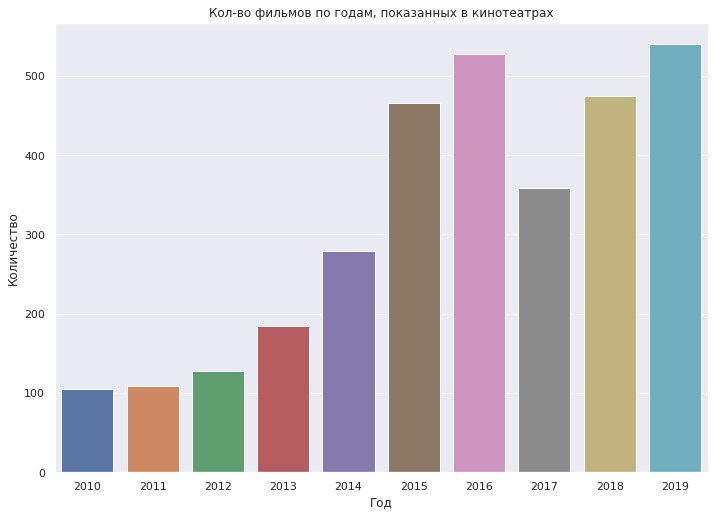

In [70]:
sns.barplot(x='start_year', y='released_films', data=film_release)
plt.title('Кол-во фильмов по годам, показанных в кинотеатрах')
plt.xlabel('Год')
plt.ylabel('Количество')
plt.show()

#### Шаг 3.3 Посмотрим на график доли фильмов, выходивших в прокат каждый год.

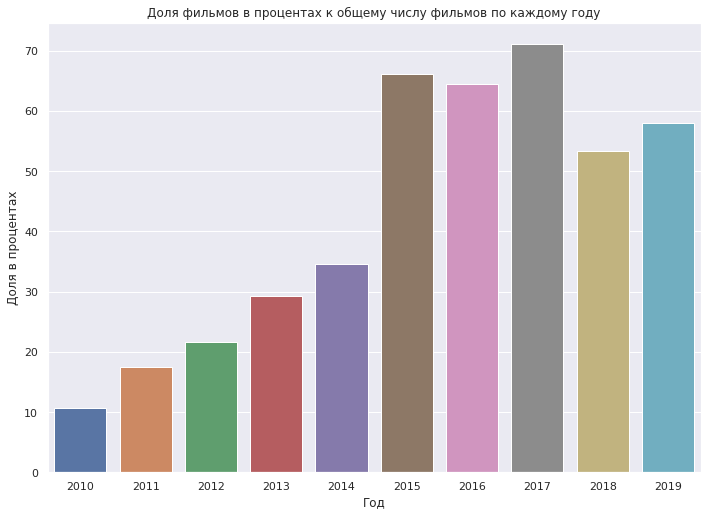

In [71]:
sns.barplot(x='start_year', y='ratio', data=film_release)
plt.title('Доля фильмов в процентах к общему числу фильмов по каждому году')
plt.xlabel('Год')
plt.ylabel('Доля в процентах')
plt.show()

#### Вывод


Глядя на график "Кол-во фильмов по годам, показанных в кинотеатрах" видим постепенный рост показа фильмов до 2016 года, в 2017 падение - затем опять рост. Это может быть связано согласно нашим данным, что вообще в принципе в 2017 году меньше всего фильмов. Возможно не урожайный год в пране продуктивности.
По графику "Доля фильмов в процентах к общему числу фильмов по каждому году" - рост до 2015, затем падение и рост к 2017, затем опять падение и рост к 2019 году. Тут причину понять трудно, но возможно это связано с прокатными удостоверениями, а так же неуверенностью прокатчиков в успехе фильмов.

- Изучите, как менялась динамика проката по годам. В каком году сумма сборов была минимальной? А максимальной?

#### Шаг 3.4 Посмотрим динамику проката по годам.

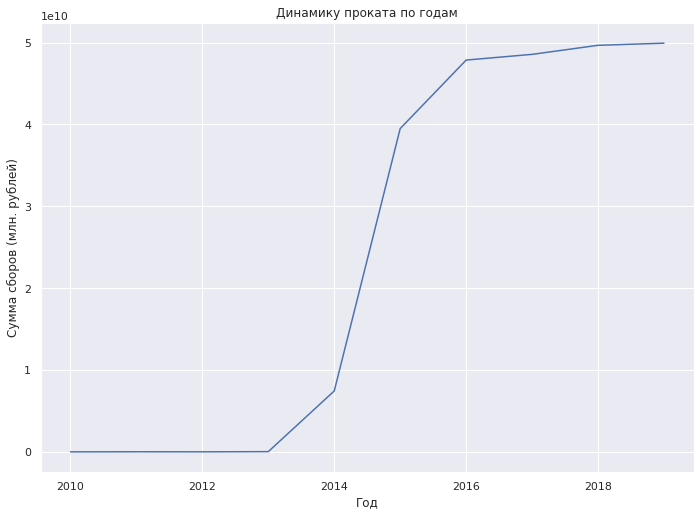

In [72]:
sns.lineplot(data=film_release, x='start_year', y='year_amount')
plt.title('Динамику проката по годам')
plt.xlabel('Год')
plt.ylabel('Сумма сборов (млн. рублей)')
plt.show()

#### Вывод

Динамика прокатных сборов по годам в принципе положительная. Заметен резкий рост после 2013 года. Тут все просто - с каждым годом увеличивалось количество фильмов вышедших в прокат или просто не хватает данных. После 2016 года незначительный, но все-таки рост.

- С помощью сводной таблицы посчитайте среднюю и медианную сумму сборов для каждого года.

#### Шаг 3.5 Отобразим на графике среднюю и медианную сумму сборов для каждого года.

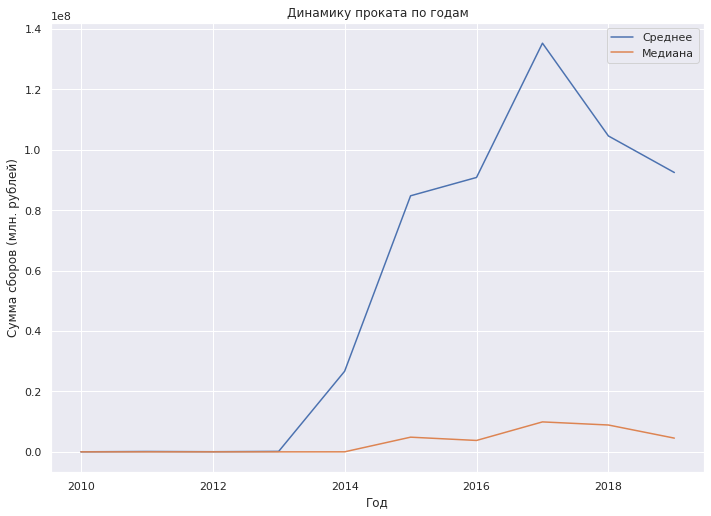

In [73]:
sns.lineplot(data = film_release, x = 'start_year', y = 'mean', label = "Среднее")
sns.lineplot(data = film_release, x = 'start_year', y = 'median', label = "Медиана")
plt.title('Динамику проката по годам')
plt.xlabel('Год')
plt.ylabel('Сумма сборов (млн. рублей)')
plt.show()

#### Вывод

До 2013 года из-за небольшого количества статистики все одинаково. А дальше резкое расхождение среднего и медианы.
Исходя из того, что для больших выборок лучше использовать медиану можно сделать вывод, что есть очень кассово прибыльные фильмы (это видно по среднему значению), но в большинстве случаев согласно медиане сборы не высокие.

Тут все аналогично зарплатам: если 9 человек получают 30 т.р., а один 200 т.р., то среденее 47 т.р, а медиана все равно 30 т.р.

- Определите, влияет ли возрастное ограничение аудитории («6+», «12+», «16+», «18+» и т. д.) на сборы фильма в прокате в период с 2015 по 2019 год? Фильмы с каким возрастным ограничением собрали больше всего денег в прокате? Меняется ли картина в зависимости от года? Если да, предположите, с чем это может быть связано.

#### Шаг 3.6 Создадим датафрейм для анализа влияния  возрастного ограничения аудиториина сборы фильма в прокате в период с 2015 по 2019 год.

В датафрейм добавим столбцы:
- `start_year` - год выхода в прокат
- `age_restriction` - категория ограничения по возрасту
- `year_amount` - прокатные сбору по текущему году и каждой категории

In [74]:
restriction_amount = data.query('start_year >= 2015').groupby(['start_year', 'age_restriction'])['box_office'].agg(['sum', 'count']).reset_index()
restriction_amount = restriction_amount.rename(columns={'sum': 'year_amount', 'count': 'total_films'})
restriction_amount

,start_year,age_restriction,year_amount,total_films
0,2015,«0+» - для любой зрительской аудитории,"379,054,578.37",39
1,2015,«12+» - для детей старше 12 лет,"13,616,085,158.91",74
2,2015,«16+» - для детей старше 16 лет,"11,368,120,870.27",168
3,2015,«18+» - запрещено для детей,"5,432,308,367.44",132
4,2015,«6+» - для детей старше 6 лет,"8,701,799,371.41",53
5,2016,«0+» - для любой зрительской аудитории,"150,825,507.67",42
6,2016,«12+» - для детей старше 12 лет,"12,204,446,524.39",82
7,2016,«16+» - для детей старше 16 лет,"16,664,548,541.74",182
8,2016,«18+» - запрещено для детей,"6,793,929,818.87",151
9,2016,«6+» - для детей старше 6 лет,"12,053,146,008.24",70


#### Шаг 3.6 Построим гистаграмму для категорий.

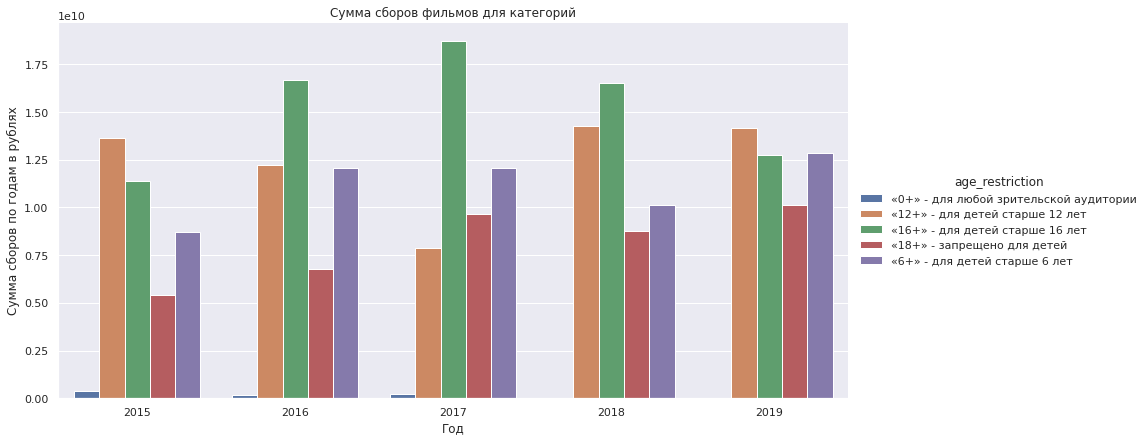

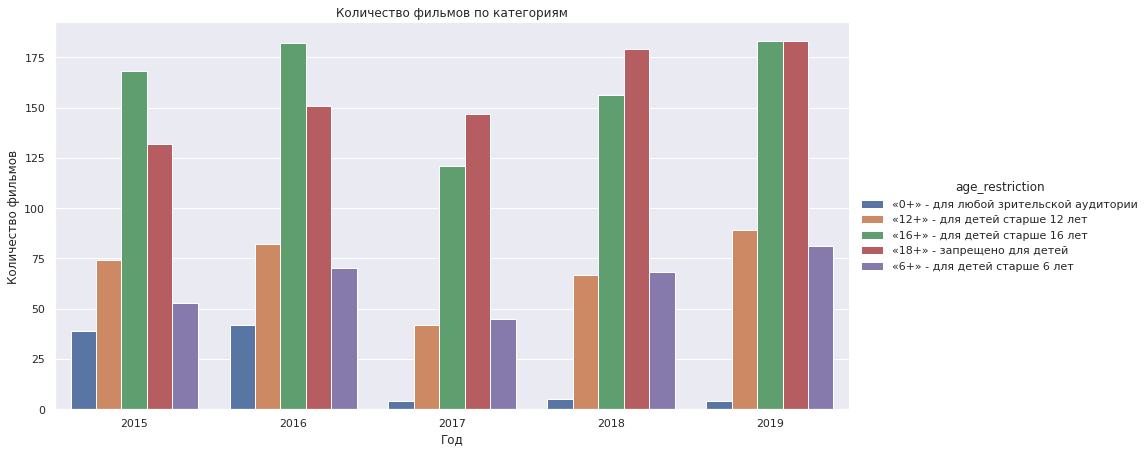

In [75]:
sns.catplot(x='start_year', y='year_amount', hue='age_restriction', data = restriction_amount, kind = 'bar', height=6, aspect=2)
plt.title('Сумма сборов фильмов для категорий')
plt.xlabel('Год')
plt.ylabel('Сумма сборов по годам в рублях')
plt.show()
sns.catplot(x='start_year', y='total_films', hue='age_restriction', data=restriction_amount, kind='bar', height=6, aspect=2)
plt.title('Количество фильмов по категориям')
plt.xlabel('Год')
plt.ylabel('Количество фильмов')
plt.show()

#### Вывод

При сравнении категориальных значений возрастного ценза можно обнаружить следуюющее:
- Категория `0+` имеет наименьшее количество фильмов по годам и самые маленькие сборы;
- Категория `6+` соличество фильмов проваливается только в 2017 году, а сборы уменьшаются в 2018.
- Категория `12+` с 2017 года количество переходит в качетво, растет количество - растут сборы
- Категория `16+` с 16+ ситуация другая: 2015-2106 обоюдный рост, а с 2017 года обратный эффект - растет количество, но падают сборы
- Категория `18+` в 2017 чуть снизилось количество, но сборы выше, чем в 2015-2016., далее количетво растет, а сборы на уровне 2017 года - контент видимо ухудшился




### Шаг 4. Исследуйте фильмы, которые получили государственную поддержку

На этом этапе нет конкретных инструкций и заданий — поищите интересные закономерности в данных. Посмотрите, сколько выделяют средств на поддержку кино. Проверьте, хорошо ли окупаются такие фильмы, какой у них рейтинг.

#### Шаг 4.1 Для дальнейшего анализа добавим наш датафрейм еще 2 столбца

- `gov_support` - сумма гос. поддержки (сумма возвратных и неводозвратных средств)
- `profit` - прибыльность фильма (разница между сборами и общим бюджетом)
- `rent` - в своем роде рентабельность фильма

и сразу выведем на информацию о таблице.

In [76]:
data['gov_support'] = data['refundable_support'] + data['nonrefundable_support']
data['profit'] = data['box_office'] - data['budget']
data['rent'] = data['box_office'] / data['budget'] -1
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7486 entries, 0 to 7485
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  7486 non-null   object        
 1   puNumber               7486 non-null   int64         
 2   show_start_date        7486 non-null   datetime64[ns]
 3   type                   7486 non-null   object        
 4   film_studio            7470 non-null   object        
 5   production_country     7486 non-null   object        
 6   director               7477 non-null   object        
 7   producer               6918 non-null   object        
 8   age_restriction        7486 non-null   object        
 9   refundable_support     332 non-null    float64       
 10  nonrefundable_support  332 non-null    float64       
 11  budget                 332 non-null    float64       
 12  financing_source       332 non-null    object        
 13  rat

Все 332 бюджетных фильма на месте.

#### Шаг 4.2 Посмотрим первые 10 строк таблицы

In [77]:
data.loc[data['budget'].isna() == False].head(10)

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,...,ratings,genres,box_office,start_year,head_director,head_genre,ratio_budget,gov_support,profit,rent
1281,Пока еще жива,111005313,2013-10-11 12:00:00,Художественный,"АНО содействия развитию кинематографии ""Ангел-...",Россия,А.Атанесян,"А.Атанесян, М.Бабаханов, Р.Бутко",«16+» - для детей старше 16 лет,0.00,...,8.10,"драма, мелодрама","365,353.60",2013,А.Атанесян,драма,33.37,"26,500,000.00","-79,046,546.40",-1.00
1448,Бесславные придурки,111003314,2014-03-28 12:00:00,Художественный,"ООО ""Компания ""АТК-Студио""",Россия,А.Якимчук,А.Тютрюмов,«12+» - для детей старше 12 лет,0.00,...,NaN,NaN,"28,140.00",2014,А.Якимчук,NaN,70.00,"26,000,000.00","-37,114,717.00",-1.00
1498,Невидимки,111004213,2013-09-10 12:00:00,Художественный,"ООО ""Компания ""РЕАЛ-ДАКОТА""",Россия,"Р.Давлетьяров, С.Комаров","Р.Давлетьяров, А.Котелевский, А.Олейников",«12+» - для детей старше 12 лет,0.00,...,5.30,"комедия, фантастика","19,957,031.50",2013,Р.Давлетьяров,комедия,61.27,"107,847,945.00","-156,066,458.50",-0.89
1524,БЕРЦЫ,111004314,2014-05-05 12:00:00,Художественный,"ООО ""Студия ""Пассажир""",Россия,Е.Миндадзе (псевдоним Катя Шагалова),Л.Антонова,«16+» - для детей старше 16 лет,0.00,...,4.20,драма,"55,917.50",2014,Е.Миндадзе (псевдоним Катя Шагалова),драма,69.01,"28,000,000.00","-40,518,222.50",-1.00
1792,Братья Ч,111004414,2014-04-23 12:00:00,Художественный,"ООО ""Студия ""Пассажир""",Россия,М.Угаров,"А.Миндадзе, Л.Антонова",«16+» - для детей старше 16 лет,0.00,...,6.40,драма,"232,100.00",2014,М.Угаров,драма,62.48,"25,000,000.00","-39,783,022.00",-0.99
1854,Тайна Сухаревой башни. Чародей равновесия,114000115,2015-02-18 12:00:00,Анимационный,"ООО ""Студия ""Мастер-Фильм""",Россия,С.Серегин,А.Герасимов,«6+» - для детей старше 6 лет,0.00,...,6.10,"мультфильм, фэнтези, история","15,078,858.60",2015,С.Серегин,мультфильм,48.22,"25,000,000.00","-36,771,141.40",-0.71
1870,А зори здесь тихие,111002915,2015-03-16 12:00:00,Художественный,"ООО ""Компания ""Реал-Дакота""",Россия,Р.Давлетьяров,NaN,«12+» - для детей старше 12 лет,"50,000,000.00",...,8.50,"драма, военный, история","249,166,767.70",2015,Р.Давлетьяров,драма,68.00,"150,000,000.00","28,578,373.70",0.13
1871,Две женщины,111013714,2014-10-02 12:00:00,Художественный,"ООО ""Продюсерский Центр ""Хорошо Продакшн"", Rez...","Россия, Франция, Латвия",В.Глаголева,Н.Иванова,«12+» - для детей старше 12 лет,0.00,...,6.70,драма,"4,731,239.50",2014,В.Глаголева,драма,53.94,"46,502,299.00","-81,478,827.50",-0.95
1903,Призрак,111001815,2015-03-02 12:00:00,Художественный,"ООО ""Водород 2011""",Россия,А.Войтинский,С.Сельянов,«6+» - для детей старше 6 лет,0.00,...,7.00,"триллер, боевик, приключения","352,804,320.40",2015,А.Войтинский,триллер,53.74,"75,000,000.00","213,252,817.40",1.53
1912,Ведьма,111002215,2015-03-05 12:00:00,Художественный,"ООО ""Кинокомпания ""Ракурс""",Россия,Д.Федоров,В.Сидоренко,«16+» - для детей старше 16 лет,0.00,...,7.40,"фэнтези, приключения, драма","51,907.50",2015,Д.Федоров,фэнтези,70.00,"34,000,000.00","-48,519,522.50",-1.00


Из талблицы сразу видим, что есть убыточные фильмы

#### Шаг 4.3 Посмтотрим статистику по столбцу `profit`

In [78]:
data['profit'].describe()

count              332.00
mean        -1,838,225.53
std        309,173,739.98
min     -1,971,477,243.41
25%        -70,050,755.75
50%        -42,204,189.00
75%        -10,470,284.27
max      2,913,568,690.79
Name: profit, dtype: float64

и столбцу `rent`

In [79]:
data['rent'].describe()

count   332.00
mean     -0.22
std       1.63
min      -1.00
25%      -0.98
50%      -0.84
75%      -0.12
max      18.21
Name: rent, dtype: float64

Картина неприглядная, неужели столько убыточных фильмов. И среднее, и медиана, и межквартильный размах все в минусе..

#### Шаг 4.3 Узнаем название самого прибыльного, убыточного и количество прибыльных фильмов

In [80]:
data.loc[data['profit'] == data['profit'].min()][['title', 'budget', 'box_office', 'rent', 'profit', 'ratings']]

,title,budget,box_office,rent,profit,ratings
7114,Тайна Печати Дракона,"2,305,074,303.00","333,597,059.59",-0.86,"-1,971,477,243.41",5.80


In [81]:
data.loc[data['profit'] == data['profit'].max()][['title', 'budget', 'box_office', 'rent', 'profit', 'ratings']]


,title,budget,box_office,rent,profit,ratings
7456,Холоп,"160,000,000.00","3,073,568,690.79",18.21,"2,913,568,690.79",6.80


In [82]:
data.loc[data['profit'] > 0][['title', 'budget', 'box_office', 'rent', 'profit', 'ratings']]

,title,budget,box_office,rent,profit,ratings
1870,А зори здесь тихие,"220,588,394.00","249,166,767.70",0.13,"28,578,373.70",8.50
1903,Призрак,"139,551,503.00","352,804,320.40",1.53,"213,252,817.40",7.00
1987,Елки Лохматые,"80,000,000.00","121,225,633.80",0.52,"41,225,633.80",5.00
2005,Снежная Королева 2: Перезаморозка,"252,489,571.00","313,489,846.50",0.24,"61,000,275.50",6.50
2058,Дуxless 2,"107,142,857.00","446,163,511.00",3.16,"339,020,654.00",6.60
...,...,...,...,...,...,...
7453,Фиксики против кработов,"270,000,000.00","387,590,521.72",0.44,"117,590,521.72",7.50
7456,Холоп,"160,000,000.00","3,073,568,690.79",18.21,"2,913,568,690.79",6.80
7466,Иван Царевич и Серый Волк 4,"190,000,000.00","501,069,235.00",1.64,"311,069,235.00",6.70
7474,Вторжение,"944,000,000.00","962,409,758.00",0.02,"18,409,758.00",5.70


In [83]:
print("Доля прибыльных фильмов с гос. поддержкой: {:.0%}".format(data.loc[data['profit'] > 0]['profit'].count() /  data['profit'].count()))

Доля прибыльных фильмов с гос. поддержкой: 23%


- Самый убыточный фильм "Тайна Печати Дракона"
- Самый прибыльный "Холоп"
- И имеем всего 76 прибыльных фильмов из 332 с участием гос. поддержки. Доля прибыльных фильмов всего 23%

#### Шаг 4.4 Посмотрим как менялась господдержка и ее доля по годам

In [84]:
goverment_support = pd.DataFrame()
goverment_support['released_films'] = data.groupby('start_year')['gov_support'].count()
goverment_support['support'] = data.groupby('start_year')['gov_support'].sum()
goverment_support['ratio'] = data.groupby('start_year')['ratio_budget'].mean()
goverment_support['rent'] = data.loc[(data['budget'].isna() == False)].groupby('start_year')['box_office'].sum() / data.groupby('start_year')['budget'].sum() - 1
goverment_support['profit'] = data.groupby('start_year')['profit'].sum()
goverment_support['rating'] = data.groupby('start_year')['ratings'].mean()
goverment_support = goverment_support.reset_index()

In [85]:
goverment_support

,start_year,released_films,support,ratio,rent,profit,rating
0,2010,0,0.00,NaN,NaN,0.00,6.72
1,2011,0,0.00,NaN,NaN,0.00,6.53
2,2012,0,0.00,NaN,NaN,0.00,6.55
3,2013,2,"134,347,945.00",47.32,-0.92,"-235,113,004.90",6.51
4,2014,16,"572,002,299.00",53.26,-0.22,"-294,919,759.40",6.52
5,2015,86,"3,656,241,459.00",54.10,-0.27,"-2,137,237,781.86",6.30
6,2016,61,"4,303,155,482.00",55.99,-0.21,"-1,612,352,535.90",6.35
7,2017,41,"3,183,971,662.00",49.16,0.53,"3,771,531,818.96",6.32
8,2018,56,"3,446,969,465.00",52.35,0.39,"2,783,846,569.25",6.38
9,2019,70,"4,904,000,000.00",50.37,-0.23,"-2,886,046,182.37",6.49


С 2010 по 2012 пуcтота. Можно удалить.

In [86]:
goverment_support = goverment_support.dropna().reset_index(drop=True)

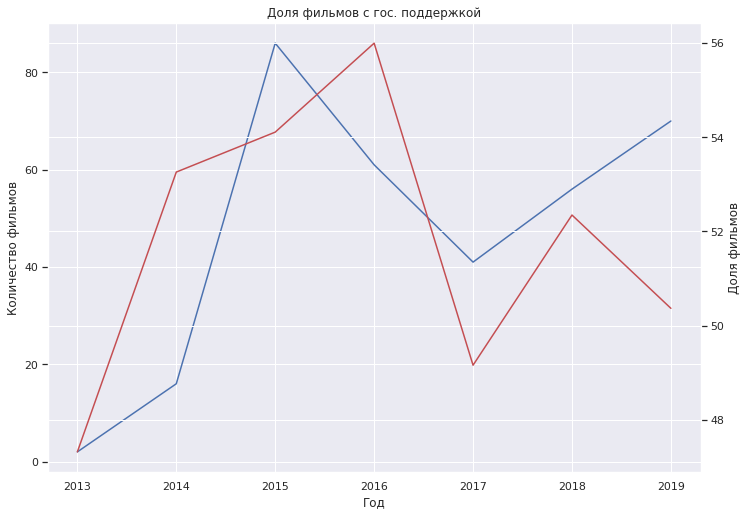

In [87]:
fig, ax = plt.subplots()
sns.lineplot(data = goverment_support, x ='start_year', y ='released_films', ax=ax)
plt.title('Доля фильмов с гос. поддержкой')
plt.xlabel('Год')
plt.ylabel('Количество фильмов')
ax2 = ax.twinx()
sns.lineplot(data = goverment_support, x ='start_year', y ='ratio', ax=ax2, color='r')
plt.ylabel('Доля фильмов')
plt.show()

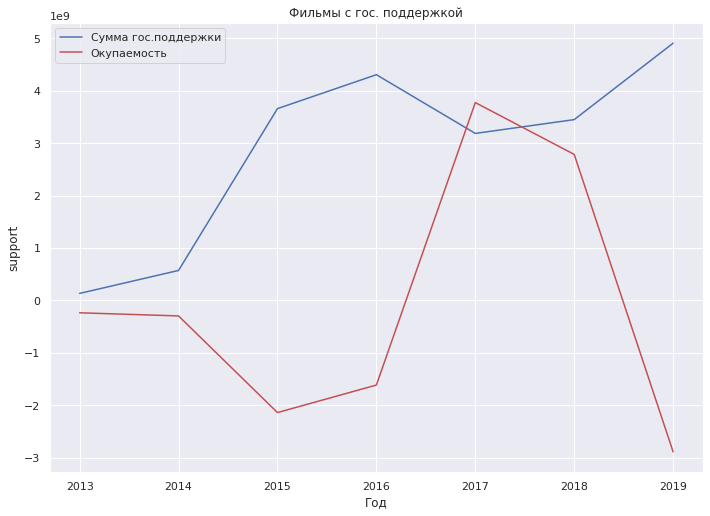

In [88]:
sns.lineplot(data = goverment_support, x ='start_year', y ='support', label = 'Сумма гос.поддержки')
plt.title('Фильмы с гос. поддержкой')
plt.xlabel('Год')
sns.lineplot(data = goverment_support, x ='start_year', y ='profit', color='r', label = 'Окупаемость')
plt.show()


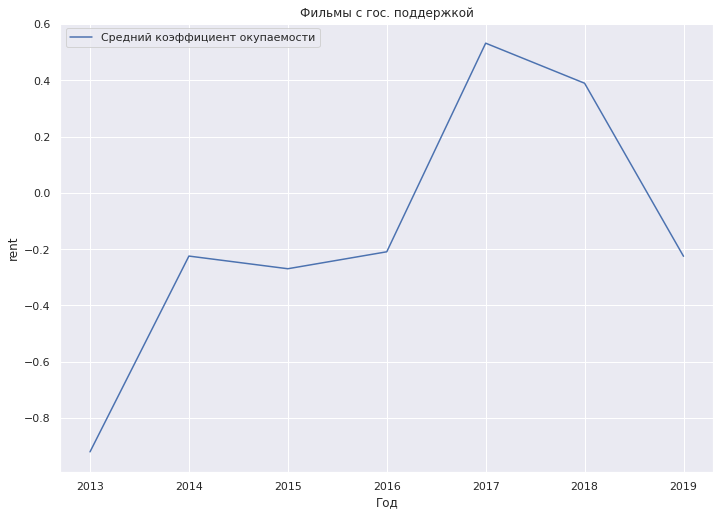

In [89]:
sns.lineplot(data = goverment_support, x ='start_year', y ='rent', label = 'Средний коэффициент окупаемости')
plt.title('Фильмы с гос. поддержкой')
plt.xlabel('Год')
plt.show()


In [90]:
print('Коэффициент корреляции между кассовыми сборами и рейтингом:', data['box_office'].corr(data['ratings']))

Коэффициент корреляции между кассовыми сборами и рейтингом: 0.08915448511149027


#### Вывод

В среднем доля гос. поддержки крутится в районе 50%. Остальное частные средства.

Доля фильмов с гос. поддержкой и количество фильмов с гос. поддержкой идут примерно одинаково. В 2019 году доля гос.поддержки упала. 

А вот зависимости между объемом гос.поддержки и окупаемости не прослеживается. Только в 2017 вышли в плюс. Видимо вопросы нужно задавать режиссерам почему их фильмы не окупаются.

#### Шаг 4.5 Посмотрим на примере Топ-10 фильмов: по дотациям государства, по прибыльности, по рейтингу и доли бюджета  

Первая десятка по дотациям:

In [91]:
data_top_films = pd.pivot_table(data.loc[data['budget'].isna() == False],
               index=["title", "head_director", "head_genre", "start_year"],   
               values=["box_office", "budget", "gov_support", "rent", "profit", "ratings", "ratio_budget"]
              )
data_top_films.sort_values(by = 'gov_support', ascending = False).head(10)

,,,,box_office,budget,gov_support,profit,ratings,ratio_budget,rent
title,head_director,head_genre,start_year,,,,,,,
Союз спасения,А.Кравчук,история,2019,"717,703,185.53","980,000,000.00","500,000,000.00","-262,296,814.47",6.00,51.02,-0.27
Вторжение,Ф.Бондарчук,фантастика,2019,"962,409,758.00","944,000,000.00","500,000,000.00","18,409,758.00",5.70,52.97,0.02
Дуэлянт,А.Мизгирев,драма,2016,"364,285,139.60","684,200,536.00","450,000,000.00","-319,915,396.40",6.60,65.77,-0.47
Экипаж,Н.Лебедев,драма,2016,"1,402,255,390.00","635,283,867.00","442,104,482.00","766,971,523.00",7.60,69.59,1.21
Движение вверх,А.Мегердичев,спорт,2017,"2,779,686,144.00","590,192,191.00","400,000,000.00","2,189,493,953.00",7.50,67.77,3.71
Легенда о Коловрате,И.Шурховецкий,история,2017,"590,405,065.00","500,012,729.00","350,000,000.00","90,392,336.00",6.40,70.00,0.18
Матильда,А.Учитель,фэнтези,2017,"511,775,548.00","1,032,905,957.00","300,000,000.00","-521,130,409.00",7.70,29.04,-0.50
Ледокол,Н.Хомерики,драма,2016,"337,069,662.80","430,000,000.00","300,000,000.00","-92,930,337.20",6.50,69.77,-0.22
Девятая,Н.Хомерики,детектив,2019,"55,876,887.40","453,704,666.00","300,000,000.00","-397,827,778.60",5.80,66.12,-0.88


Из 10 самых дотируемых фильмов по сумме - всего 4 прибыльных, `Движение вверх` - успех, а `Тайна Печати Дракона` - полный провал.

Первая десятка по прибыли:

In [92]:
data_top_films.sort_values(by = 'profit', ascending = False).head(10)

,,,,box_office,budget,gov_support,profit,ratings,ratio_budget,rent
title,head_director,head_genre,start_year,,,,,,,
Холоп,К.Шипенко,комедия,2019,"3,073,568,690.79","160,000,000.00","60,000,000.00","2,913,568,690.79",6.80,37.50,18.21
Движение вверх,А.Мегердичев,спорт,2017,"2,779,686,144.00","590,192,191.00","400,000,000.00","2,189,493,953.00",7.50,67.77,3.71
Т-34,А.Сидоров,драма,2018,"2,271,754,004.52","563,784,717.00","180,000,000.00","1,707,969,287.52",6.50,31.93,3.03
Последний богатырь,Д.Дьяченко,комедия,2017,"1,655,037,688.00","352,477,575.00","100,000,000.00","1,302,560,113.00",6.80,28.37,3.70
Экипаж,Н.Лебедев,драма,2016,"1,402,255,390.00","635,283,867.00","442,104,482.00","766,971,523.00",7.60,69.59,1.21
Притяжение (2016),Ф.Бондарчук,фантастика,2016,"1,038,321,489.00","357,142,857.00","250,000,000.00","681,178,632.00",5.60,70.00,1.91
Ёлки Новые,Д.Киселев,комедия,2017,"855,451,052.00","174,381,922.00","100,000,000.00","681,069,130.00",5.80,57.35,3.91
Три богатыря и принцесса Египта,К.Феоктистов,мультфильм,2017,"759,226,773.00","174,464,395.00","50,000,000.00","584,762,378.00",5.50,28.66,3.35
Самый Лучший День,А.Першин (псевдоним Ж.Крыжовников),комедия,2015,"683,029,061.40","130,619,336.00","63,000,000.00","552,409,725.40",4.70,48.23,4.23


Тут все как на ладони - это десять самых прибыльных фильмов

Первая десятка по рейтингу:

In [93]:
data_top_films.sort_values(by = 'ratings', ascending = False).head(10)

,,,,box_office,budget,gov_support,profit,ratings,ratio_budget,rent
title,head_director,head_genre,start_year,,,,,,,
БОЛЬШОЙ,В.Тодоровский,криминал,2016,"228,578,204.00","320,000,000.00","210,000,000.00","-91,421,796.00",8.50,65.62,-0.29
А зори здесь тихие,Р.Давлетьяров,драма,2015,"249,166,767.70","220,588,394.00","150,000,000.00","28,578,373.70",8.50,68.00,0.13
Миллиард,Р.Прыгунов,драма,2019,"408,646,665.70","240,041,307.00","140,000,000.00","168,605,358.70",8.20,58.32,0.70
Пока еще жива,А.Атанесян,драма,2013,"365,353.60","79,411,900.00","26,500,000.00","-79,046,546.40",8.10,33.37,-1.00
Мотылёк,К.Худяков,драма,2017,"410,058.00","63,170,000.00","37,346,881.00","-62,759,942.00",8.00,59.12,-0.99
Байкал - Сердце мира 3D,А.Попова,семейный,2019,"15,032,948.00","33,000,000.00","3,000,000.00","-17,967,052.00",8.00,9.09,-0.54
Однажды,Р.Давлетьяров,драма,2015,"12,748,398.30","156,360,666.00","97,000,000.00","-143,612,267.70",7.90,62.04,-0.92
Герой,К.Оганисян,фэнтези,2019,"172,871,342.04","250,000,000.00","120,000,000.00","-77,128,657.96",7.90,48.00,-0.31
Рок,И.Шахназаров,криминал,2017,"476,180.00","59,937,470.00","40,000,000.00","-59,461,290.00",7.80,66.74,-0.99


А вот рейтинг никак не зависит гос.поддержки и сборов. Как правило такие фильмы "Не для всех"... А возможно слабая рекламная компания и люди их просто посмотрели потом дома.

Первая десятка по доли гос. поддержки:

In [94]:
data_top_films.sort_values(by = 'ratio_budget', ascending = False).head(10)

,,,,box_office,budget,gov_support,profit,ratings,ratio_budget,rent
title,head_director,head_genre,start_year,,,,,,,
Наследники (2015),В.Хотиненко,мюзикл,2015,"194,780.00","50,218,741.00","35,153,119.00","-50,023,961.00",6.10,70.00,-1.00
Мифы,А.Молочников,комедия,2017,"50,451,949.00","64,285,714.00","45,000,000.00","-13,833,765.00",4.80,70.00,-0.22
Преображение (2015),Т.Воронецкая,ужасы,2016,"56,800.00","37,142,857.00","26,000,000.00","-37,086,057.00",5.70,70.00,-1.00
Экспириенс,Е.Татаров,драма,2015,"36,550.00","37,142,857.00","26,000,000.00","-37,106,307.00",4.70,70.00,-1.00
Тряпичный союз,М.Местецкий,комедия,2015,"1,957,738.51","84,285,714.00","59,000,000.00","-82,327,975.49",6.30,70.00,-0.98
Воин (2015),А.Андрианов,боевик,2015,"196,572,438.40","114,285,714.00","80,000,000.00","82,286,724.40",7.80,70.00,0.72
Принцесса и дракон,М.Нефедова,мультфильм,2018,"83,366,328.66","114,285,714.00","80,000,000.00","-30,919,385.34",5.20,70.00,-0.27
Чудо-юдо,А.Лукичев,мультфильм,2017,"55,108,014.76","57,142,857.00","40,000,000.00","-2,034,842.24",5.20,70.00,-0.04
Дуxless 2,Р.Прыгунов,драма,2015,"446,163,511.00","107,142,857.00","75,000,000.00","339,020,654.00",6.60,70.00,3.16


8 из 10 фильмов при максимальной гос. поддержке убыточные. Да и рейтинги ниже среднего у убыточных картин. Тут скорее всего - провал создателей..

Первая десятка по минимальной доли гос. поддержки:

In [95]:
data_top_films.sort_values(by = 'ratio_budget').head(10)

,,,,box_office,budget,gov_support,profit,ratings,ratio_budget,rent
title,head_director,head_genre,start_year,,,,,,,
За гранью реальности,А.Богуславский,приключения,2017,"126,713,450.16","136,230,333.00","6,000,000.00","-9,516,882.84",5.20,4.40,-0.07
Танцы насмерть,А.Волгин,фантастика,2016,"9,680,744.00","90,278,063.00","6,000,000.00","-80,597,319.00",4.00,6.65,-0.89
Грех,А.Михалков (псевдоним А.Кончаловский),драма,2019,"54,243,202.71","779,941,965.00","60,000,000.00","-725,698,762.29",6.90,7.69,-0.93
Байкал - Сердце мира 3D,А.Попова,семейный,2019,"15,032,948.00","33,000,000.00","3,000,000.00","-17,967,052.00",8.00,9.09,-0.54
Крякнутые каникулы,В.Лакисов,мультфильм,2015,"69,693,747.93","399,075,326.00","40,000,000.00","-329,381,578.07",5.40,10.02,-0.83
Тайна Печати Дракона,О.Степченко,приключения,2019,"333,597,059.59","2,305,074,303.00","270,000,000.00","-1,971,477,243.41",5.80,11.71,-0.86
Тайна Снежной королевы,Н.Бондарчук,мюзикл,2015,"1,434,072.50","215,860,000.00","25,300,000.00","-214,425,927.50",7.20,11.72,-0.99
Территория,А.Мельник,детектив,2015,"72,578,317.40","500,000,000.00","60,000,000.00","-427,421,682.60",6.80,12.00,-0.85
Рай (2016),А.Кончаловский,военный,2016,"51,704,986.00","287,802,711.00","35,000,000.00","-236,097,725.00",6.80,12.16,-0.82


И тут первые 9 из 10 убыточные..

#### Шаг 4.6 В заключении посмотрим наиболее бюджетируемых режиссеров и жанры

In [96]:
data_director = pd.DataFrame()
data_director['all_films'] = data.loc[data['budget'].isna() == False].groupby('head_director')['gov_support'].count()
data_director['support_films'] = data.loc[data['budget'].isna() == False].groupby('head_director')['gov_support'].sum()
data_director['total_profit'] = data.loc[data['budget'].isna() == False].groupby('head_director')['profit'].sum()
data_director = data_director.reset_index()
data_director.sort_values(by = 'all_films', ascending = False).head(10)

,head_director,all_films,support_films,total_profit
213,Р.Давлетьяров,5,"459,847,945.00","-471,167,304.56"
221,С.Андреасян,4,"325,000,000.00","157,694,169.34"
97,Д.Дьяченко,4,"351,000,000.00","1,624,203,322.12"
29,А.Котт,3,"129,000,000.00","-248,209,730.77"
193,Н.Хомерики,3,"660,000,000.00","-351,276,001.77"
160,К.Шипенко,3,"312,000,000.00","3,122,841,549.79"
108,Д.Шмидт,3,"215,000,000.00","698,312,261.00"
66,А.Цицилин,3,"350,000,000.00","-321,836,566.75"
2,А.Аксененко,3,"90,000,000.00","-11,938,915.40"
226,С.Мокрицкий,3,"202,510,000.00","183,897,036.95"


Больше всех дотаций у Давлетьярова, почти полмиллиарда и все убыток...

Самый кассовый режиссер К. Шипенко:

In [97]:
data_director.sort_values(by = 'total_profit', ascending = False).iloc[0]

head_director          К.Шипенко
all_films                      3
support_films     312,000,000.00
total_profit    3,122,841,549.79
Name: 160, dtype: object

Самый убыточный режиссер О. Степченко:

In [98]:
data_director.sort_values(by = 'total_profit').iloc[0]

head_director         О.Степченко
all_films                       1
support_films      270,000,000.00
total_profit    -1,971,477,243.41
Name: 200, dtype: object

In [99]:
data.loc[data['budget'].isna() == False, 'budget'].count()

332

In [100]:
data_genre = pd.DataFrame()
data_genre['all_films'] = data.loc[data['budget'].isna() == False].groupby('head_genre')['gov_support'].count()
data_genre['ratio_all_films_genres'] = data_genre['all_films'] / data.loc[data['budget'].isna() == False, 'budget'].count()
data_genre['support_films'] = data.loc[data['budget'].isna() == False].groupby('head_genre')['gov_support'].sum()
data_genre['rent'] = data.loc[(data['budget'].isna() == False)].groupby('head_genre')['box_office'].sum() / data.groupby('head_genre')['budget'].sum() - 1
data_genre['total_profit'] = data.loc[data['budget'].isna() == False].groupby('head_genre')['profit'].sum()
data_genre = data_genre.reset_index().sort_values(by = 'all_films', ascending = False).head(10)
data_genre

,head_genre,all_films,ratio_all_films_genres,support_films,rent,total_profit
5,драма,93,0.28,"5,314,406,632.00",-0.15,"-1,664,598,299.96"
7,комедия,74,0.22,"3,218,282,945.00",1.08,"6,749,752,492.33"
10,мультфильм,31,0.09,"2,461,520,000.00",-0.07,"-420,031,530.34"
16,триллер,15,0.05,"769,645,285.00",-0.49,"-676,225,035.86"
9,мелодрама,15,0.05,"398,000,000.00",-0.94,"-896,016,153.77"
18,фантастика,11,0.03,"1,406,000,000.00",0.05,"130,370,365.39"
19,фэнтези,11,0.03,"1,032,900,000.00",-0.57,"-1,344,287,157.03"
17,ужасы,10,0.03,"355,000,000.00",0.26,"146,245,564.35"
2,военный,9,0.03,"422,000,866.00",-0.21,"-268,236,353.20"
12,приключения,7,0.02,"696,000,000.00",-0.64,"-2,168,039,141.38"


Больше потрачено на драмы, они же и убыточны. А вот комедии очень прибыльные.

### Шаг 5. Напишите общий вывод

### Общий вывод

На этапе предобработки: 
- объединены два датафрейма в один с устранением недочетов и приведением к единому типу данных;
- некорретные значения в стоблце  `ratings ` заменены на NaN;
- в столбце `production_country` заменены два пропуска на `Россия`;
- в столбце `film_studio` удалось в ручном режиме устранить 2 пропуска, остальные оставлены как есть;
- по максимуму зачищены категориальные значения (убраны пробелы, лишние символы) написании названий;
- дубликаты прокатных удотоверений возможны, т.к. по одному удостоверению может быть не один фильм;
- обнаружены и исравлены неявные дубликаты в стране производства фильмов
- в количественных переменных восстановлены значения бюджета и кассовых сборов для фильмов с гос. поддержкой;
- добавлены необходимые для дальнейшего анализа столбцы `start_year`, `head_director`, `head_genre`, `ratio_budget`, `gov_support`, `profit`;

Проведя исследовательский анализ были выявлены зависимости:

В общем количестсве фильмов:
- самый кассовый год 2019-й - `4 904 000 000.00 рублей` при самом большом количестве фильмов в прокате - `540`; 
- динамика проката по годам положительная по 2019 год - рост;
- самая кассовая категория "16+", меньше всего сборов по "0+", но там и меньше всего фильмов;

В фильмах с гос. поддержкой:
- выявлены самый кассовый фильм - `"Холоп" - 2 913 568 690.79`  и самый убыточный - `"Тайна Печати Дракона" - -1 971 477 243.41`;
- доля прибыльных фильмов в нашем датасете всего 23%;
- зависимости между гос. поддержкой и окупаемости не обнаружено. Коэфициент корреляции - ` -0.2`;
- максимальные дотации получили `Союз спасения` и `Вторжение` по `500 000 000.00`;
- на рейтинг абсолютно не влияет ни бюджет, ни дотации. Тут голосует зритель. И голосует не всегда в пользу бюджета;
- самый бюджетируемый режисер Р. Давлетьяров, он же и самый убыточный (почти полмиллиарда и почти все убыток...);
- и по жанрам больше всего денег пущено на драмы, а самые прибыльные оказались комедии - `6 749 752 492.33`;
- самый кассовый режиссер - К. Шипенко: `3 122 841 549.79`;
- самый убыточный - О.Степченко: `-1 971 477 243.41`, но доля гос. поодержки у его фильма всего 11,7 %;
- прибыльность как и рейтинг абсолютно не зависит от уровня гос. поддержки.
